In [84]:
from pathlib import Path
import os
from os import listdir
from os.path import isfile, join
from scipy.io.wavfile import read
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi, sqrt, exp
import scipy
import librosa
import librosa.display
plt.style.use('seaborn-poster')
%matplotlib inline
from sklearn.linear_model import LinearRegression
from scipy import signal
from tqdm import tqdm
import random
import math
from scipy.signal import find_peaks

In [2]:
root_dir = Path(os.getcwd())
wav_path = root_dir/'wav_database'
sample_rate = 16000

In [3]:
# sample_word = 'off'

In [4]:
# wav_samples = [wav_path/sample_word/f for f in listdir(wav_path/sample_word) if isfile(join(wav_path/sample_word, f))]
# print(len(wav_samples))

speechcommands data is sampled at 16 kHz -> 62.5 us. Total length of audio recording is 1s.

Original Praat shape of broadband -> 256 x 991, narrowband -> 512 x 445

Compute short-term spectral analysis: Compute a spectrum of a discrete set of time points in the audio signal.

Spectrogram Parameters:
- Window Length (s): (broadband: 0.005, narrowband: 0.03) Duration of analysis window, affects bandwidth of signal.
    - Given 62.5 us between each sample, to get a 0.005 s window, we take 80 samples. For 0.03 s window -> 480 samples.
- Max Freq (Hz): (broadband & narrowband: 8000 kHz) Highest frequency we want to see. Don't make this more than 2x sample frequency.
- Time Step (s): (broadband & narrowband: 0.01 s) 
    - For a time step of 0.001 s, we move forward by 16 samples per window.
- Frequency Step (Hz): (broadband & narrowband: 20 Hz) 

Formant Acquisition Parameters:
- Time Step (s): (25% of window length)
- Number of Formants: usually 5
- Formant Ceiling (Hz): 6000. Usually 5000-5500 for adults, and can be up to 8000 for children.
- Window Length (s): (0.025) 400 samples
- Preemphasis: (P = 30 Hz). This fits the equation: e^(-2 * pi * P * 6.25e-5), where 6.25e-5 is the sampling period of the sound (1/16000) and P = 30, giving us around 98%, close to a typical value.

# Utility Functions

In [5]:
def get_wavs(sample_word, wav_path):
    wav_samples = [wav_path/sample_word/f for f in listdir(wav_path/sample_word) if isfile(join(wav_path/sample_word, f))]

    # Remove wav_samples that cannot be read (not .wav type)
    i = 0
    while i < len(wav_samples):
        try:
            _ = read(wav_samples[i])
            i += 1
        except:
            del wav_samples[i]
    
    return wav_samples

In [6]:
def convolve_pad(signal, window):
    signal = np.convolve(signal, np.ones(window), 'valid') / window
    signal = np.concatenate([np.array([signal[0]]*(window//2)), signal, np.array([signal[len(signal)-1]]*(window//2-1))])
    return signal

In [228]:
def DFT(x):
    """
    x: 1D real-valued signal as a list
    """

    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(-2j * np.pi * k * n / N)
    
    X = np.dot(e, x)
    
    return X

# Make Formants
Courtesy of https://sail.usc.edu/~lgoldste/Ling582/Week%209/LPC%20Analysis.pdf

In [8]:
def pre_emphasize(signal, pre_emph_factor):
    # Perform pre-emphasis
    pre_emph_wav = []
    for i in range(len(signal)-1):
        pre_emph_wav.append(signal[i+1] - pre_emph_factor*signal[i])
    pre_emph_wav = np.array(pre_emph_wav)
    return pre_emph_wav

In [9]:
def lpc_coef(signal, window_size, M, ibeg):
    iend = ibeg + window_size # iend is the last sample in the window
    Y = signal[ibeg:iend] # Take window_size data points from signal
    if not len(Y) == window_size:
        Y = np.concatenate([Y, [0]*(window_size-len(Y))])
#         Y = Y * np.hamming(window_size)

    # X is a (M x window_size) matrix
    X = []
    for i in range(1,M):
        ibeg_delay = (ibeg - i) if (ibeg - i >= 0) else 0
        iend_delay = (iend - i) if (iend - i >= 0) else 0
        signal_delay = signal[ibeg_delay:iend_delay]
        X.append(np.concatenate([[0]*(window_size-len(signal_delay)), signal_delay]))
    X = np.array(X).T

    acoef = LinearRegression().fit(X, Y).coef_
    acoef = np.concatenate([np.array([1]), -acoef])

    return acoef

In [10]:
def lpc_fft(acoef, num_fft_points, pad):
    acoef_padded = np.concatenate([np.array(acoef), np.array([0]*(num_fft_points-len(acoef)))])
    num = 1
    if (pad):
        den = acoef
    else:
        den = acoef_padded
    transfer = scipy.signal.freqz(num, den)
    lpc = np.log(abs(transfer[1]))
    lpcf = transfer[0]

    return lpcf, lpc

In [11]:
def lpc_wgdf(acoef, num_fft_points):
    acoef_padded = np.concatenate([np.array(acoef), np.array([0]*(num_fft_points-len(acoef)))])
    
    fftx = DFT(acoef_padded)
    fftnx = DFT(acoef_padded * np.arange(len(acoef_padded)))
    
    fftx_real = fftx.real
    fftx_imag = fftx.imag
    fftnx_real = fftnx.real
    fftnx_imag = fftnx.imag
    
    abs_fftx = abs(fftx)
    
    wgdf = []
    
    for i in range(len(abs_fftx) // 2):
        num = fftx_real[i]*fftnx_real[i] + fftx_imag[i]*fftnx_imag[i]
        exp = 0.4/num_fft_points * i + 0.8
        den = np.power(abs_fftx[i], exp)
        wgdf.append(den)

    return np.array(wgdf)

In [12]:
def lpc(signal, window_size, M, num_fft_points, pad=False, use_wgdf=False):
    """
    Calculate LPC coefficients, then do FFT on the coefficients to get formant profile of spectrogram.
    
    To plot lpc_diagram:
        plt.imshow(lpc_diagram, extent=[0, 20000, 0, 8000])
        plt.xlabel("couple hundreds of seconds")
        plt.ylabel("Hz")
    
    To plot lpc_history of one spectrum (eg. sample 30):
        plt.plot(lpcf*sample_rate/(2*np.pi), lpc_history[30])
    If it's using wgdf, scaling is:
        plt.plot(lpcf[::4]*sample_rate/(2*np.pi), lpc_history[30])
        
    """
    # Usually 0.25 * window_size = 120. In this case, window_size=480. 
    # We pick the closest multiple of 16 to 120 to align with narrowband calculations.
    time_step = 128 
    
    lpc_history = []
    acoef_history = []
    for ibeg in range(0, len(signal), int(time_step)):
        acoef = lpc_coef(signal, window_size, M, ibeg)
        if use_wgdf:
            lpc = lpc_wgdf(acoef, num_fft_points)
            lpcf, _ = lpc_fft(acoef, num_fft_points, pad)
            lpcf = lpcf[::4]
        else:
            lpcf, lpc = lpc_fft(acoef, num_fft_points, pad)
        lpc_history.append(lpc)
        acoef_history.append(acoef)

    lpc_diagram = np.vstack(lpc_history)
    lpc_diagram = list(map(list, zip(*lpc_diagram)))[::-1]
    
    return acoef_history, lpc_history, lpcf, lpc_diagram

In [13]:
def formants(lpc_history, lpcf):
    """
    Normally we would find the derivative, and find zero-crossings where the derivative goes from pos->neg.
    However, some of the tiny peaks in the lpc curve don't actually cross 0, but close to 0.
    So we will document not just 0 crossings, but also crossings across a range slightly larger than 0, eg. [-4,4].
    Then, we will get discrete ranges of x-axis values in the lpc curve where we keep seeing crossings.
    For each discrete range, we will determine the formant as the middle of the discrete range.
    """
    formant_history = []
    crosses_between_range_history = []
    
    for i in range(len(lpc_history)):
        crosses_between_range = [False]*len(lpc_history[i]) 
        
        dx = np.gradient(lpc_history[i])*100
        for j in range(len(dx)):
            if (j == 0):
                prev_dx = dx[j]
                next_dx = dx[j+1]
            elif (j == len(dx)-1):
                prev_dx = dx[j-1]
                next_dx = dx[j]
            else:
                prev_dx = dx[j-1]
                next_dx = dx[j+1]
            
            # range set is [min_range,max_range]
            min_range = -6
            max_range = 6
            crosses_between_range[j] = (prev_dx > next_dx) and \
                                   (((prev_dx < max_range and prev_dx > min_range) and (next_dx < max_range and next_dx > min_range)) or \
                                    ((prev_dx > max_range) and (next_dx < max_range and next_dx > min_range)) or \
                                    ((prev_dx < max_range and prev_dx > min_range) and (next_dx < min_range)) or \
                                    ((prev_dx > max_range) and (next_dx < min_range)))
            
        crosses_between_range_history.append(crosses_between_range)
        
        formants = []
        seen_start = False
        for k in range(len(crosses_between_range)-1):
            if crosses_between_range[k] and not seen_start:
                seen_start = True
                start = k
            elif not crosses_between_range[k] and seen_start:
                seen_start = False
                stop = k
                if (stop - start % 2 == 0): # if this is even, you saw an odd number of True
                    start += 1 # median interpolates if even no. of True. We don't want interpolation, so drop the first True
                formants.append(lpcf[int(np.median([start, stop]))]*sample_rate/(2*np.pi))
            
        formants = np.array(formants)
        formants = formants[formants >= 200] # formant values shouldn't be less than 200
        if (len(formants) < 5):
            formants = np.concatenate([formants, np.array([0]*(5-len(formants)))])
        elif (len(formants) > 5):
            formants = formants[0:5]

        formant_history.append(formants)
    
    formant_history = np.array(formant_history).T
    
  # Defunct code that was there when we did mask_formant_with_voicing
#     new_formant_history = []
#     for f in range(len(formant_history)):
#         new_formant_history.append(np.pad(formant_history[f], pad_width=(0,125-len(formant_history[f])))) # formants must be of length 125 to avoid headaches
        
    return crosses_between_range_history, formant_history #np.array(new_formant_history)

In [14]:
def normalize(spectrogram):
    min_val = min(map(min, spectrogram))
    max_val = max(map(max, spectrogram))
    
    if not type(spectrogram).__module__ == np.__name__:
        spectrogram = np.array(spectrogram)

    normed = np.array([[0]*spectrogram.shape[1]]*spectrogram.shape[0], dtype='float64')
    for i in range(spectrogram.shape[0]):
        newval = (spectrogram[i] - min_val) / (max_val - min_val)
        normed[i] = (spectrogram[i] - min_val) / (max_val - min_val)
        
    return normed

In [15]:
def mask_formant_with_lpc(formant_history, lpc_history, threshold=0.6):
    formant_mask = []
    for l in lpc_history:
        middle_region = l[120:400]
        middle_mean = np.mean(middle_region)
        mdfa = np.mean(np.abs(np.subtract(middle_region, middle_mean)))
        mask_val = 1 if mdfa > threshold else 0
        formant_mask.append(mask_val)
        
    masked_formant_history = []
    for f in formant_history:
        masked_formant_history.append(f*formant_mask)
    
    return np.array(masked_formant_history)

In [16]:
def mask_formant_with_voicing(formant_history, discrete_voicing):
    """
    Assuming that each formant in formant_history is of length 125 (because formant time_step is 128, 16000/128=125),
    and discrete_voicing is of length 956 because narrowband time_step is 16 and convolution window effects in voicing calculations.
    We sample every 8 of discrete_voicing to get a length of 120. 
    Now the offset is just 5, pad the result with the difference between formant_history and new discrete_voicing.
    """
    resampled_discrete_voicing = discrete_voicing[0::8]
    
    masked_formant_history = []
    for f in formant_history:
        masked_formant_history.append(f*np.concatenate([discrete_voicing[0::8], [0]*(len(f)-len(discrete_voicing[0::8]))]))
    
    return np.array(masked_formant_history)

In [17]:
def formant_difference(formant_history):
    return formant_history[1] - formant_history[0]

In [18]:
# curr_wav = wav_samples[2]
# curr_wav = read(curr_wav)[1]
# acoef_history, lpc_history, lpcf, lpc_diagram = lpc(pre_emphasize(curr_wav, 0.98), window_size=480, M=14, num_fft_points=256, pad=False, use_wgdf=False)
# crosses_between_range_history, formant_history = formants(lpc_history, lpcf)

In [19]:
# for i in range(0,3):
#     plt.plot(formant_history[i])

In [20]:
# plt.imshow(lpc_diagram, extent=[0, 20000, 0, 8000])
# plt.xlabel("couple hundreds of seconds")
# plt.ylabel("Hz")

In [21]:
# print(len(lpc_history))
# # print(len(wgdf_history))
# sample = 70
# x = lpc_history[sample]
# # wgdf = wgdf_history[sample]
# plt.plot(lpcf*sample_rate/(2*np.pi), x)
# plt.plot(lpcf*sample_rate/(2*np.pi), lpc_history[30])
# # plt.plot(lpcf*sample_rate/(2*np.pi), (np.gradient(x)*100))
# plt.show()
# print(formant_history.T[sample])

# Making Spectrograms

In [22]:
def get_spectrogram(curr_wav, band):

    if band == 'broadband':
        window_size = 80 # 80 samples per window. 16 kHz sample rate -> 5 ms window 
        time_step = 16 # Move forward 16 samples per window.
        num_padding = 400 # Amount to pad by, in number of samples. Total samples = num_padding + window_size
    elif band == 'narrowband':
        window_size = 480
        time_step = 16
        num_padding = 0
    else:
        raise ValueError('Require broadband or narrowband')
        
    windows = []
    spectrums = []

    i = 0
    while (i*time_step+window_size < len(curr_wav)):
        curr_window = curr_wav[i*time_step:i*time_step+window_size]
        if len(curr_window) != window_size: # pad the last few windows that are clipped at the end
            curr_window = np.concatenate([curr_window, np.array([0]*(window_size-len(curr_window)))])
        windows.append(curr_window)
        i += 1

    for w in windows:
        window_kernel = np.hamming(window_size) # experiment with other kernels like Gaussian and Hann
        windowed = w * window_kernel
        padded = np.concatenate([windowed, np.array([0]*num_padding)])
        spectrum = abs(DFT(padded))
        spectrum = spectrum[0:len(spectrum)//2]
        spectrum = np.log(spectrum + 0.00001)
        spectrums.append(spectrum)

    spectrums = np.vstack(spectrums)
    spectrums = list(map(list, zip(*spectrums)))[::-1]
    
    return spectrums

In [23]:
def voicing(spectrogram, threshold, window):
    """
    For narrowband spectrograms, the dimensions are 240 x 970, corresponding to a range of [0:8KHz].
    Fundamental range is determined to be around 150 - 800 Hz.
    This corresponds to a spectrogram height index of 5 - 24.
    
    Threshold usually 0.7. Lower threshold to get a more lenient voicing window.
    Window usually 15.
    """
    if not type(spectrogram).__module__ == np.__name__:
        spectrogram = np.array(spectrogram)
    
    f_fund_low = 5
    f_fund_high = 24
    num_harmonics = 5

    volume_offset_spectrogram = spectrogram[0:num_harmonics*f_fund_high]
    volume_offset_amplitude = (1/(num_harmonics*f_fund_high+1)) * np.sum(volume_offset_spectrogram, axis=0)

    test_voicing_amplitude = np.array([[0]*spectrogram[0].shape[0]]*(f_fund_high-f_fund_low), dtype='float64')
    f_fund = 0
    for f in range(f_fund_low, f_fund_high):
        for i in range(1, num_harmonics+1): 
            test_voicing_amplitude[f-f_fund_low] += (spectrogram[i*f]) # This is what the paper did, but maybe isn't good (spectrogram[i*f] - volume_offset_amplitude)
    voicing_amplitude = np.ndarray.max(test_voicing_amplitude, axis=0)
    freqs_with_max_amplitude = np.ndarray.argmax(test_voicing_amplitude, axis=0)
        
    # Smooth with filter
    voicing_amplitude = np.convolve(voicing_amplitude, np.ones(window), 'valid') / window
    
    # Normalize to make discrete thresholding easier
    max_val = np.quantile(voicing_amplitude, 1)
    min_val = np.quantile(voicing_amplitude, 0)
    voicing_amplitude = (voicing_amplitude - min_val) / (max_val - min_val)

    # Create discrete voicing indicator
    discrete_voicing = np.where(voicing_amplitude > threshold, 1, 0) # threshold between 0-1. Usually 0.7

    return voicing_amplitude, discrete_voicing, freqs_with_max_amplitude

# Non-Formant Features

In [24]:
def get_range_amplitudes(spectrogram, window):
    """
    Narrowband spectrograms are 240x970. 
    Frequency range is 0 - 8KHz.
    240 - 8000 Hz
    75 - 2500 Hz -> Lower threshold for [s] sounds
    39 - 1300 Hz -> Range for [n] or noise
    """
    f_base = 0
    f_low = 39
    f_mid = 75
    f_high = 240
        
    # Obtain ranges
    fund_range_spectrogram = spectrogram[f_high-f_low:f_high-f_base] # taking f_base to f_low
    low_range_spectrogram = spectrogram[f_high-f_mid:f_high-f_low] # taking f_low to f_mid
    high_range_spectrogram = spectrogram[f_high-f_high:f_high-f_mid] # taking f_mid to f_high
    
    # Get normalized amplitude
    fund_range_amplitude = np.sum(fund_range_spectrogram, axis=0) * (1 / (f_low - f_base + 1))
    low_range_amplitude = np.sum(low_range_spectrogram, axis=0) * (1 / (f_mid - f_low + 1))
    high_range_amplitude = np.sum(high_range_spectrogram, axis=0) * (1 / (f_high - f_mid + 1))
        
    # Filter to smooth signals
    fund_range_amplitude = convolve_pad(fund_range_amplitude, window)
    low_range_amplitude = convolve_pad(low_range_amplitude, window)
    high_range_amplitude = convolve_pad(high_range_amplitude, window)

    # Normalize the 3 signals to [0,1]
    min_val = np.min([np.min(fund_range_amplitude), np.min(low_range_amplitude), np.min(high_range_amplitude)])
    max_val = np.max([np.max(fund_range_amplitude), np.max(low_range_amplitude), np.max(high_range_amplitude)])
    fund_range_amplitude = (fund_range_amplitude - min_val) / (max_val - min_val)
    low_range_amplitude = (low_range_amplitude - min_val) / (max_val - min_val)
    high_range_amplitude = (high_range_amplitude - min_val) / (max_val - min_val)
    
    return fund_range_amplitude, low_range_amplitude, high_range_amplitude

In [25]:
def get_f_indicator(spectrogram, window):
    """
    High column averages and low mean distance from average indicate the letter F!
    """
    col_avg = np.mean(spectrogram, axis=0)
    dist_from_avg = np.subtract(spectrogram, col_avg)
    mean_dist_from_avg = np.mean(np.abs(dist_from_avg), axis=0)
    
    # Filter to smooth signals
    col_avg = convolve_pad(col_avg, window)
    mean_dist_from_avg = convolve_pad(mean_dist_from_avg, window)

    # Normalize
    ca_min = np.min(col_avg)
    ca_max = np.max(col_avg)
    mdfa_min = np.min(mean_dist_from_avg)
    mdfa_max = np.max(mean_dist_from_avg)
    col_avg = (col_avg - ca_min) / (ca_max - ca_min)
    mean_dist_from_avg = (mean_dist_from_avg - mdfa_min) / (mdfa_max - mdfa_min)

    # Compute the actual [f] indicator
    # This is the column average subtracting the mean distance from average
    f_indicator = np.clip(col_avg - mean_dist_from_avg, a_min=0, a_max=None)

    return col_avg, mean_dist_from_avg, f_indicator

In [26]:
def get_s_indicator(spectrogram, window, lower_bound):
    # lower_bound around -0.1
    fund_range_amplitude, low_range_amplitude, high_range_amplitude = get_range_amplitudes(spectrogram, window)
    s_indicator = np.subtract(high_range_amplitude, np.average([fund_range_amplitude, low_range_amplitude], axis=0))
    s_indicator = np.clip(s_indicator, a_min=lower_bound, a_max=None)
    
    return s_indicator

In [27]:
def get_n_indicator(spectrogram, window, lower_bound):
    fund_range_amplitude, low_range_amplitude, high_range_amplitude = get_range_amplitudes(spectrogram, window)
    n_indicator = np.subtract(fund_range_amplitude, np.average([low_range_amplitude, high_range_amplitude], axis=0))
    n_indicator = np.clip(n_indicator, a_min=lower_bound, a_max=None)
    
    return n_indicator

In [28]:
def get_stop_indicator(spectrogram, window):
    _, low_range_amplitude, high_range_amplitude = get_range_amplitudes(spectrogram, window)
    total_amplitude = np.add(low_range_amplitude, high_range_amplitude)
    slope = np.concatenate([np.array([0]), np.diff(total_amplitude)]) # returned slope list is 1 element less than total_amplitude
    slope = convolve_pad(slope, window)
    
    return slope

# Discretization

In [154]:
def interpolate_formants(formants):
    """
    Assume formant length is 125 entries. Narrowband spectrograms have 970 columns.
    To interpolate the two types of features, we will duplicate formant values 7 or 8 times per formula:
    30*7+47*8+48*8 = 970, and 30+47+48=125.
    """
    interpolated_formants = []
    duplications = [7,8,8]*30 + [8]*35
    for f in formants:
        if len(f) != 125:
            f = np.concatenate([f, np.array([f[len(f)-1]]*(125-len(f)))])
        i_f = []
        for i in range(len(f)):
            i_f += [f[i]]*duplications[i]
        interpolated_formants.append(i_f)
    return np.array(interpolated_formants)

In [50]:
def discretize(feature_name, feature):
    if feature_name == 'formants':
        discretized_formants = []
        for f in feature: # feature is formants
            i_f = []
            for i in range(len(f)):
                base = 5
                i_f += [base * round(f[i]/base)] # round to nearest base
            discretized_formants.append(i_f)
        return np.array(discretized_formants)
    else:
        discretized = []
        if feature_name == 'stop_indicator':
            bins = [-0.02,-0.015,-0.01,-0.005,0.005,0.01,0.015,0.02,0.025,0.03,np.inf]
        elif feature_name == 'n_indicator':
            bins = [-0.25,-0.2,-0.15,-0.1,-0.05,0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,np.inf]
        elif feature_name == 's_indicator':
            bins = [-0.1,-0.05,0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,np.inf]
        elif feature_name == 'f_indicator':
            bins = [0,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,np.inf]
        elif feature_name == 'f2_minus_f1':
            bins = [0,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400,2500,2600,2700,2800,2900,3000,3100,3200,3300,3400,3500,np.inf]
        for f in feature:
            b = 0
            while not f < bins[b]:
                b += 1
            discretized.append(b)
        return np.array(discretized)

# Feature Exploration

In [31]:
""" CONSTANTS """
window = 14
window_size = 480 # narrowband = 480
M = 12
num_fft_points = 256
pad = True
pre_emph_factor = 0.98

In [32]:
narrow_csv_path = root_dir/'custom_spectrograms'/'narrowband'

narrow_specs = {'on': [], 'off': [], 'go': [], 'stop': [], 'left': [], 'right': [], 'yes': [], 'no': [], 'up': [], 'down': []}

words = ['on', 'off', 'stop', 'go', 'left', 'right', 'yes', 'no', 'up', 'down']
for w in words:
    narrow_csv_samples = [narrow_csv_path/w/f for f in listdir(narrow_csv_path/w) if isfile(join(narrow_csv_path/w, f))]
    for n in tqdm(narrow_csv_samples, desc="Obtaining Spectrograms for {cw}...".format(cw=w)):
        new_spec = pd.read_csv(n, header=None)
        for col in range(len(new_spec.columns)):
            if round(np.min(new_spec[col]), 4) == round(np.mean(new_spec[col]), 4):
                new_spec.drop(col, 1, inplace=True)
        new_spec.columns = np.arange(len(new_spec.columns))
        while len(new_spec.columns) != 970:
            new_spec.insert(len(new_spec.columns), len(new_spec.columns), new_spec[len(new_spec.columns)-1])
        narrow_specs[w].append(new_spec)

Obtaining Spectrograms for down...: 100%|████████████████████████████████████████████| 301/301 [01:56<00:00,  2.58it/s]


In [187]:
sample_word = 'on'
wav_samples = get_wavs(sample_word, wav_path)

Obtaining Spectrograms...: 100%|███████████████████████████████████████████████████████| 20/20 [00:00<00:00, 29.67it/s]


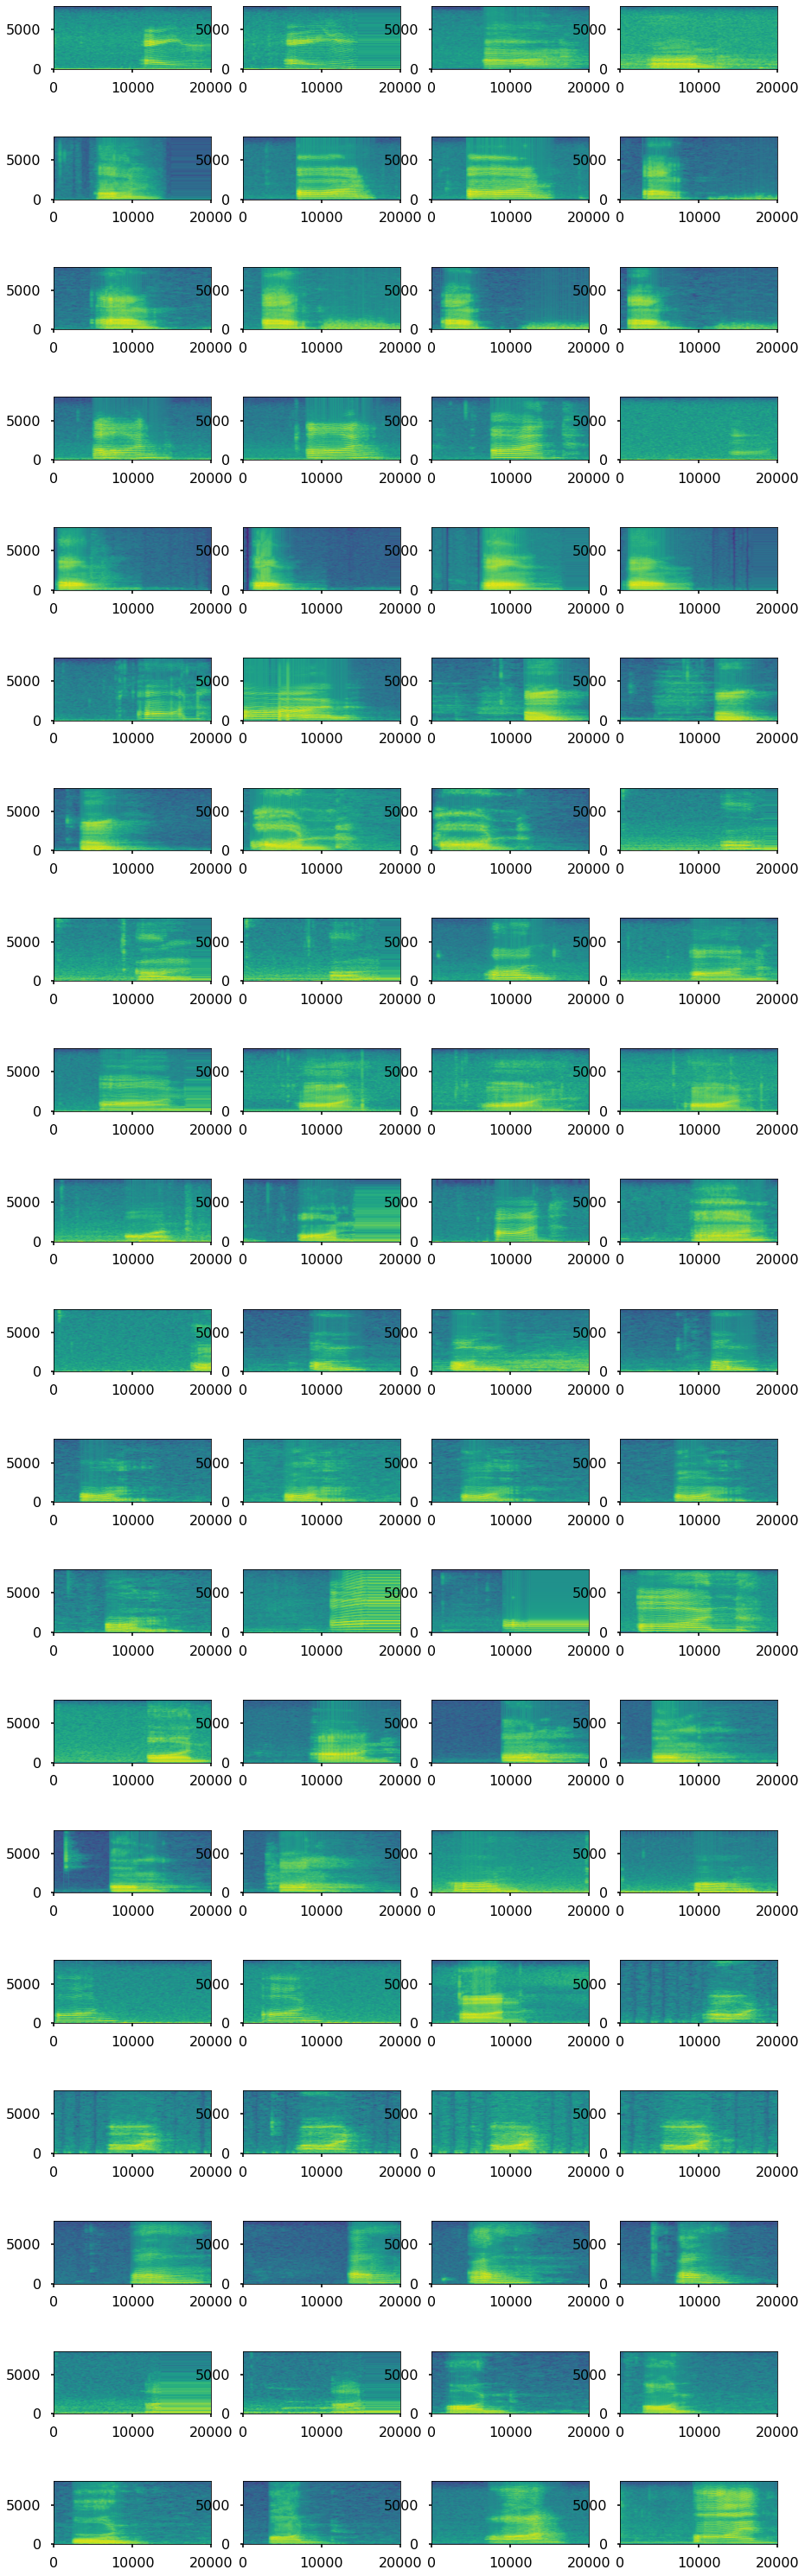

In [188]:
nrows = 20
ncols = 4
figure, ax = plt.subplots(nrows, ncols, figsize=(15, 55))

for i in tqdm(range(nrows), desc="Obtaining Spectrograms..."):
    for j in range(ncols):
        curr_spec = narrow_specs[sample_word][ncols*i+j]
        ax[i,j].imshow(curr_spec, extent=[0, 20000, 0, 8000])

Obtaining Stop-Indicator: 100%|████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 21.70it/s]


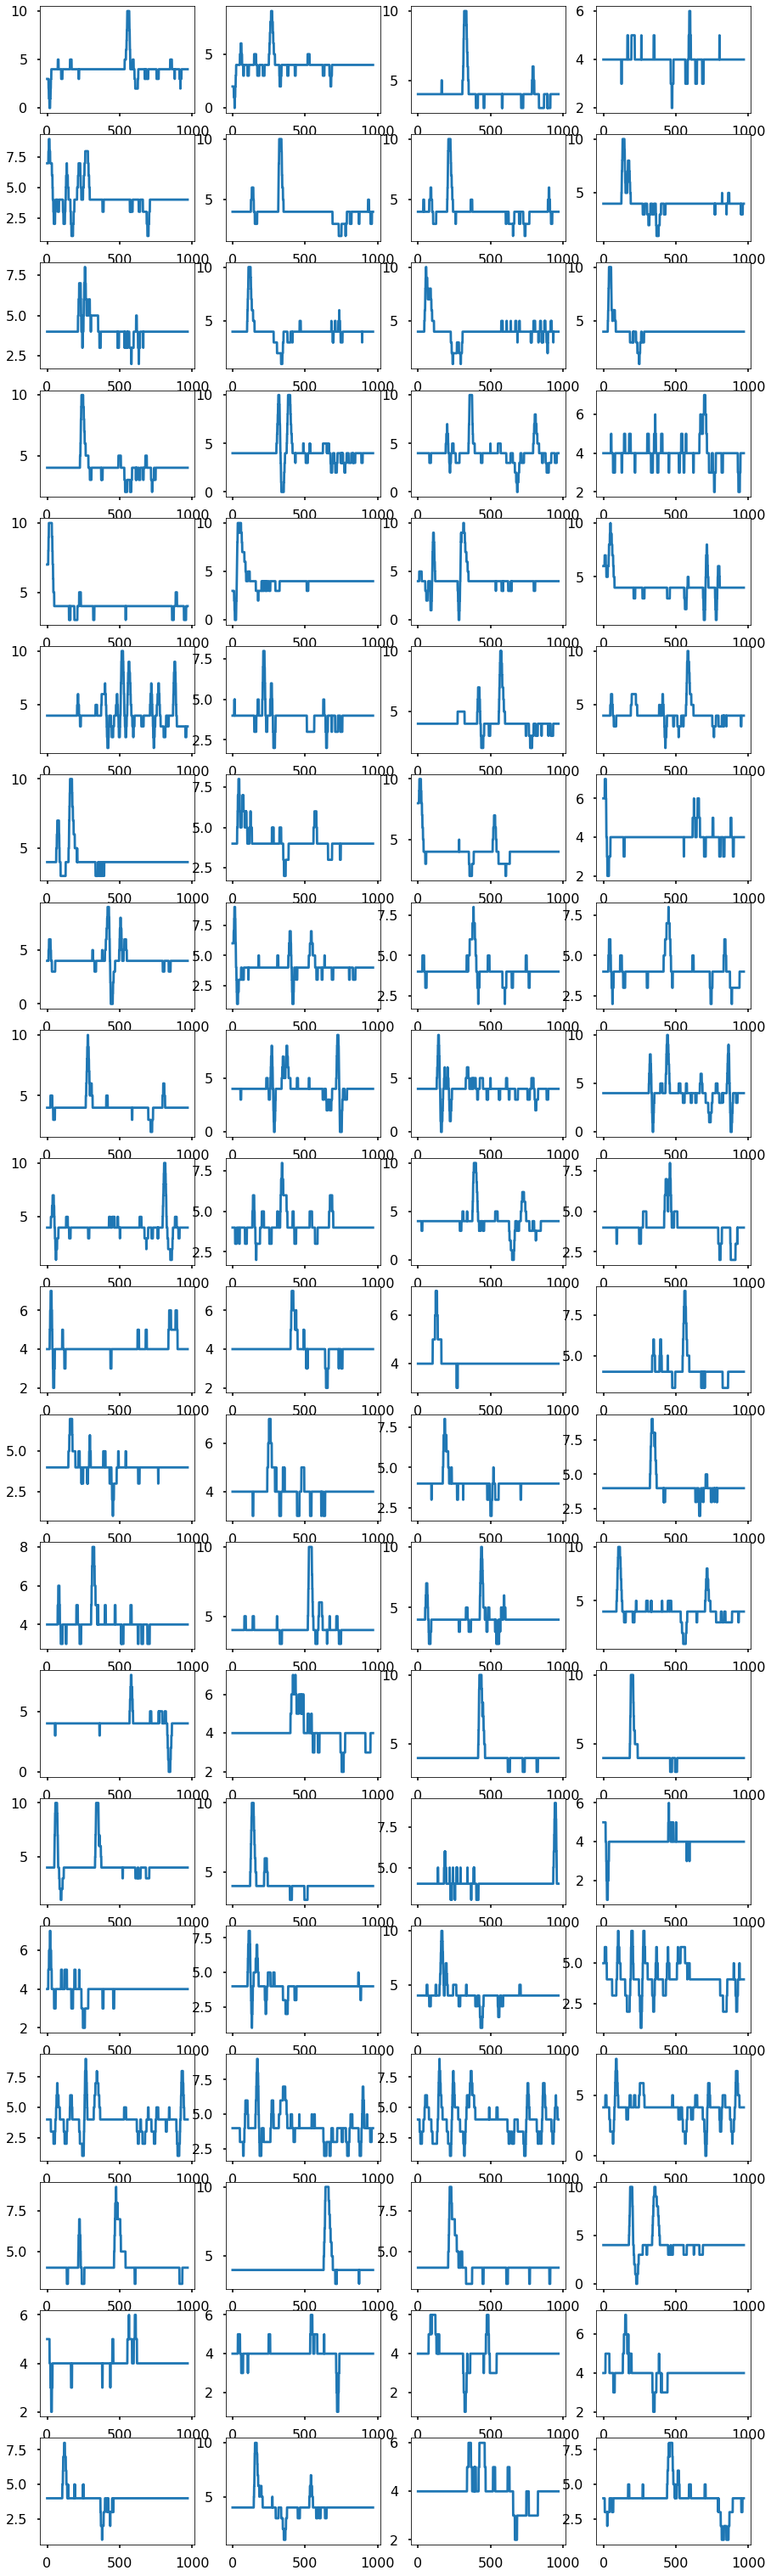

In [198]:
nrows = 20
ncols = 4
figure, ax = plt.subplots(nrows, ncols, figsize=(15, 55))

for i in tqdm(range(nrows), desc="Obtaining Stop-Indicator"):
    for j in range(ncols):
        curr_spec = narrow_specs[sample_word][ncols*i+j]
        stop_indicator = get_stop_indicator(curr_spec, window)
        discretized = discretize('stop_indicator', stop_indicator)
        ax[i,j].plot(discretized)

Obtaining F-Indicator...: 100%|████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 22.30it/s]


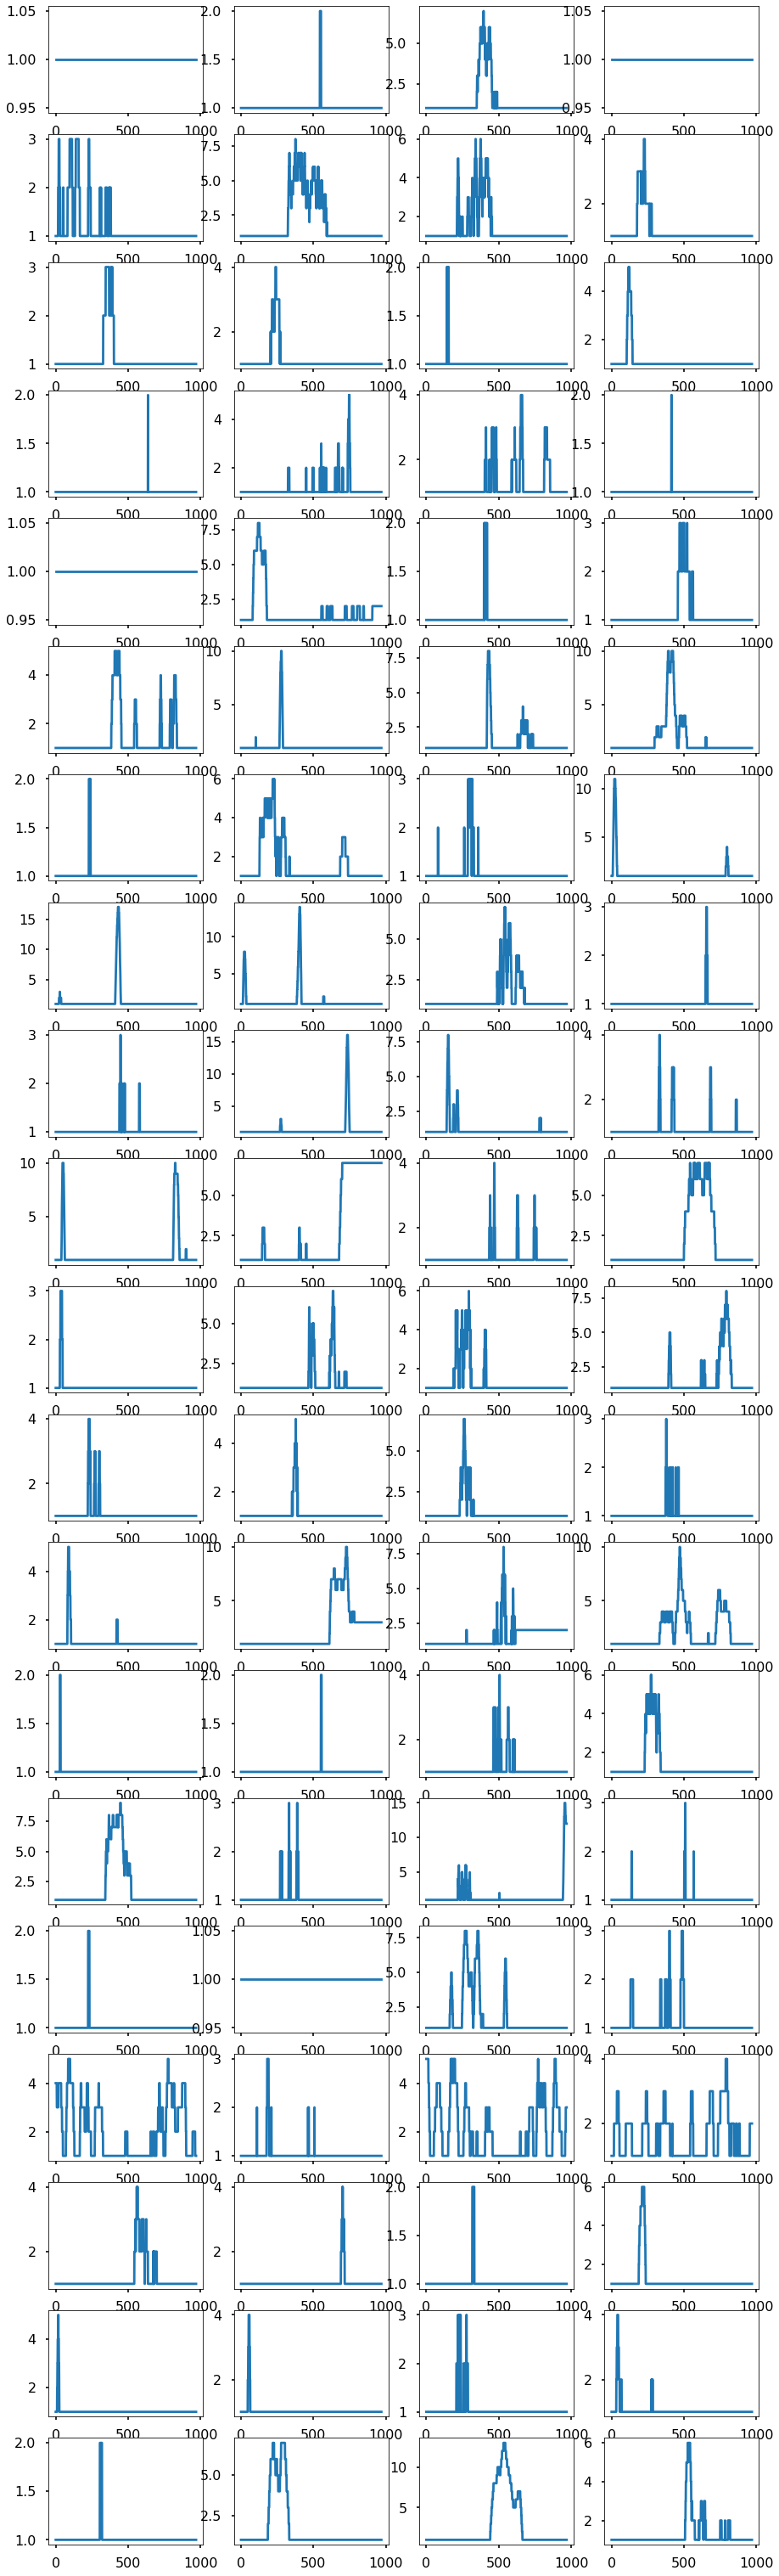

In [189]:
nrows = 20
ncols = 4
figure, ax = plt.subplots(nrows, ncols, figsize=(15, 55))

for i in tqdm(range(nrows), desc="Obtaining F-Indicator..."):
    for j in range(ncols):
        curr_spec = narrow_specs[sample_word][ncols*i+j]
        _, _, f_indicator = get_f_indicator(curr_spec, window)
        discretized = discretize('f_indicator', f_indicator)
        ax[i,j].plot(discretized)

Obtaining S-Indicator: 100%|███████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 21.06it/s]


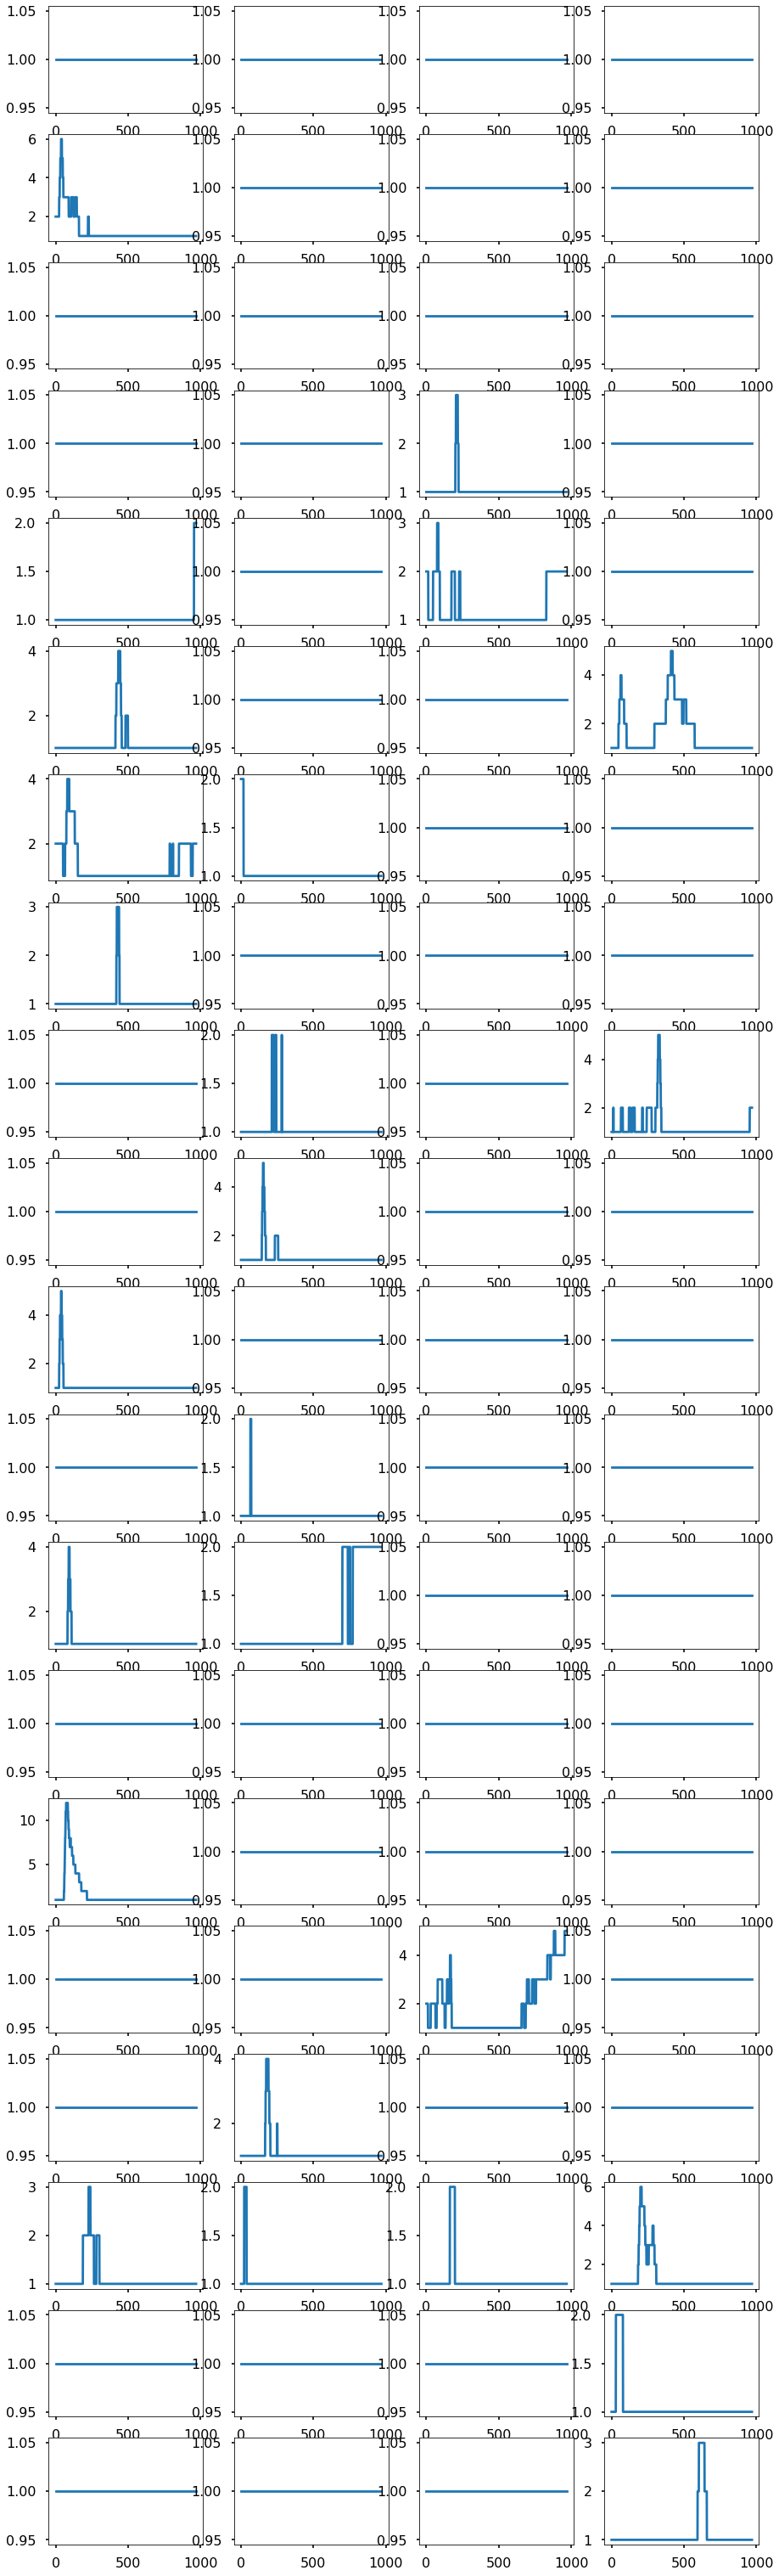

In [190]:
nrows = 20
ncols = 4
figure, ax = plt.subplots(nrows, ncols, figsize=(15, 55))

for i in tqdm(range(nrows), desc="Obtaining S-Indicator"):
    for j in range(ncols):
        curr_spec = narrow_specs[sample_word][ncols*i+j]
        s_indicator = get_s_indicator(curr_spec, window, lower_bound=-0.1)
        discretized = discretize('s_indicator', s_indicator)
        ax[i,j].plot(discretized)

Obtaining N-Indicator: 100%|███████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 21.72it/s]


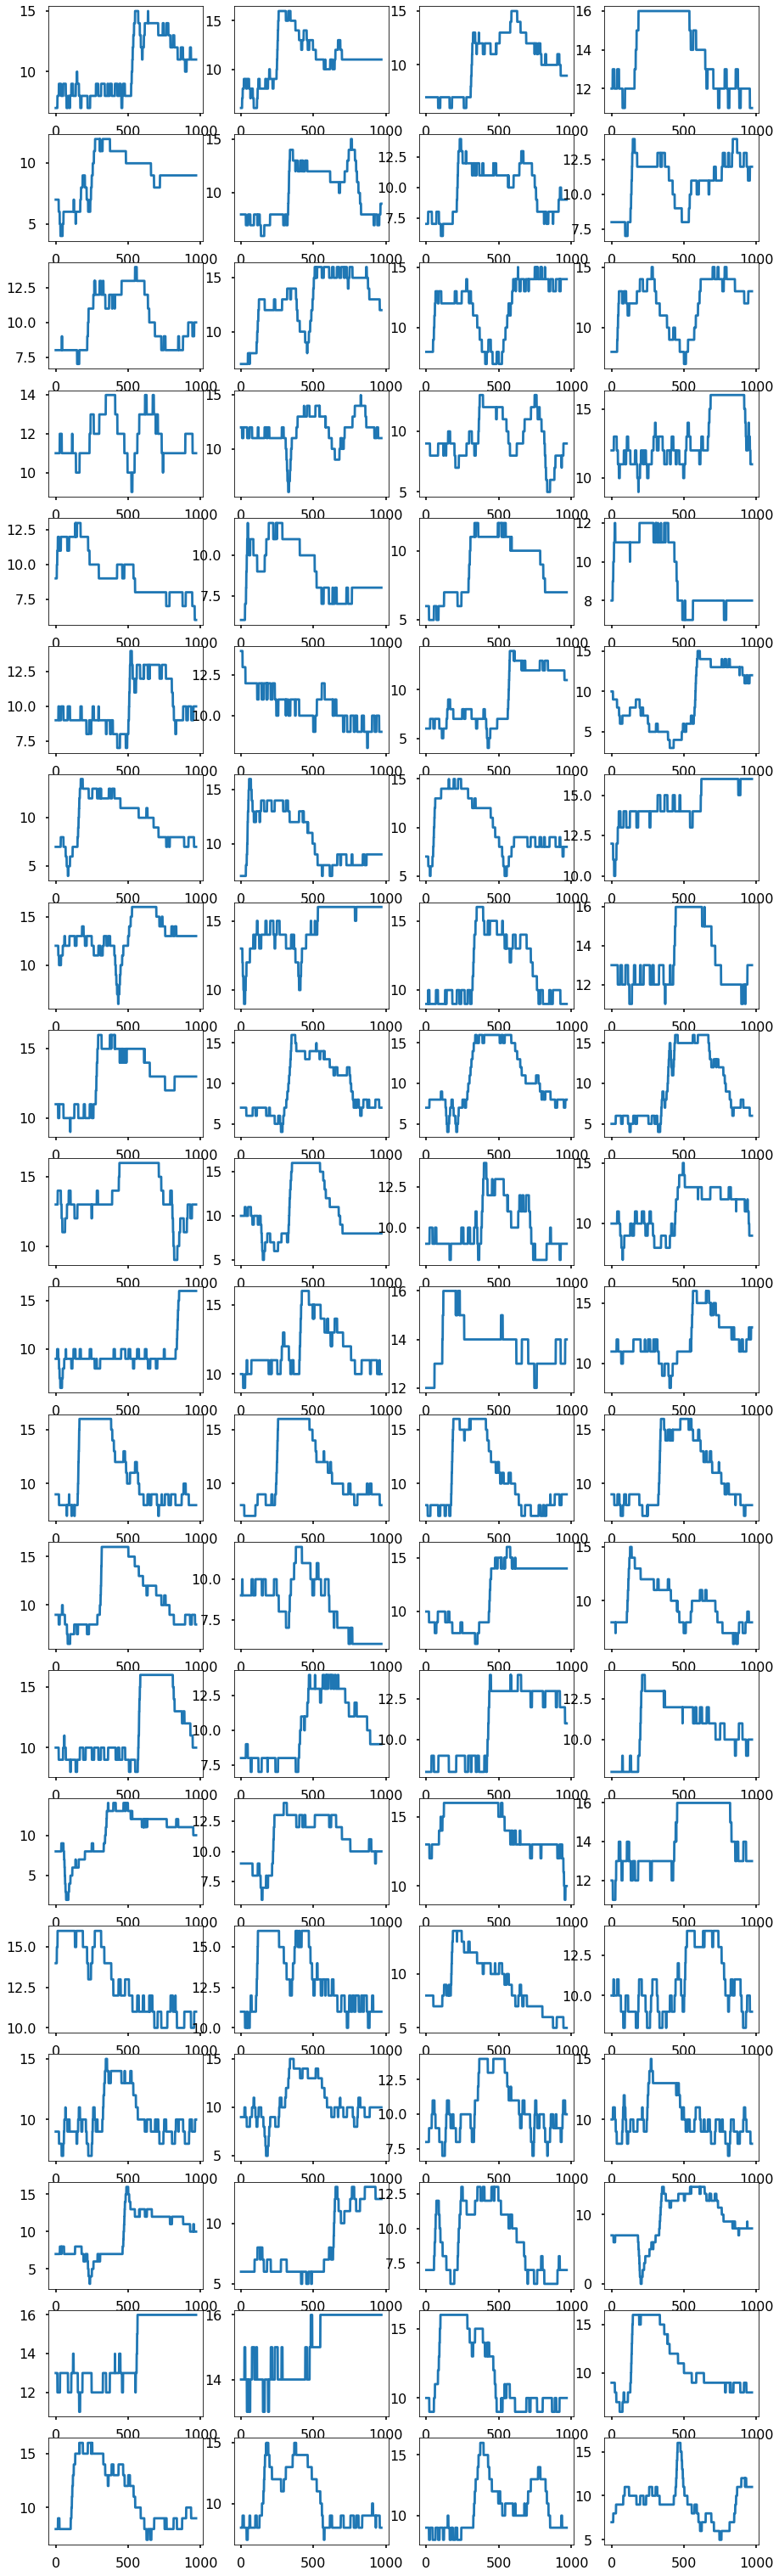

In [191]:
nrows = 20
ncols = 4
figure, ax = plt.subplots(nrows, ncols, figsize=(15, 55))

for i in tqdm(range(nrows), desc="Obtaining N-Indicator"):
    for j in range(ncols):
        curr_spec = narrow_specs[sample_word][ncols*i+j]
        n_indicator = get_n_indicator(curr_spec, window, lower_bound=-9)
        discretized = discretize('n_indicator', n_indicator)
        ax[i,j].plot(discretized)

Obtaining Stop-Indicator: 100%|████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 23.91it/s]


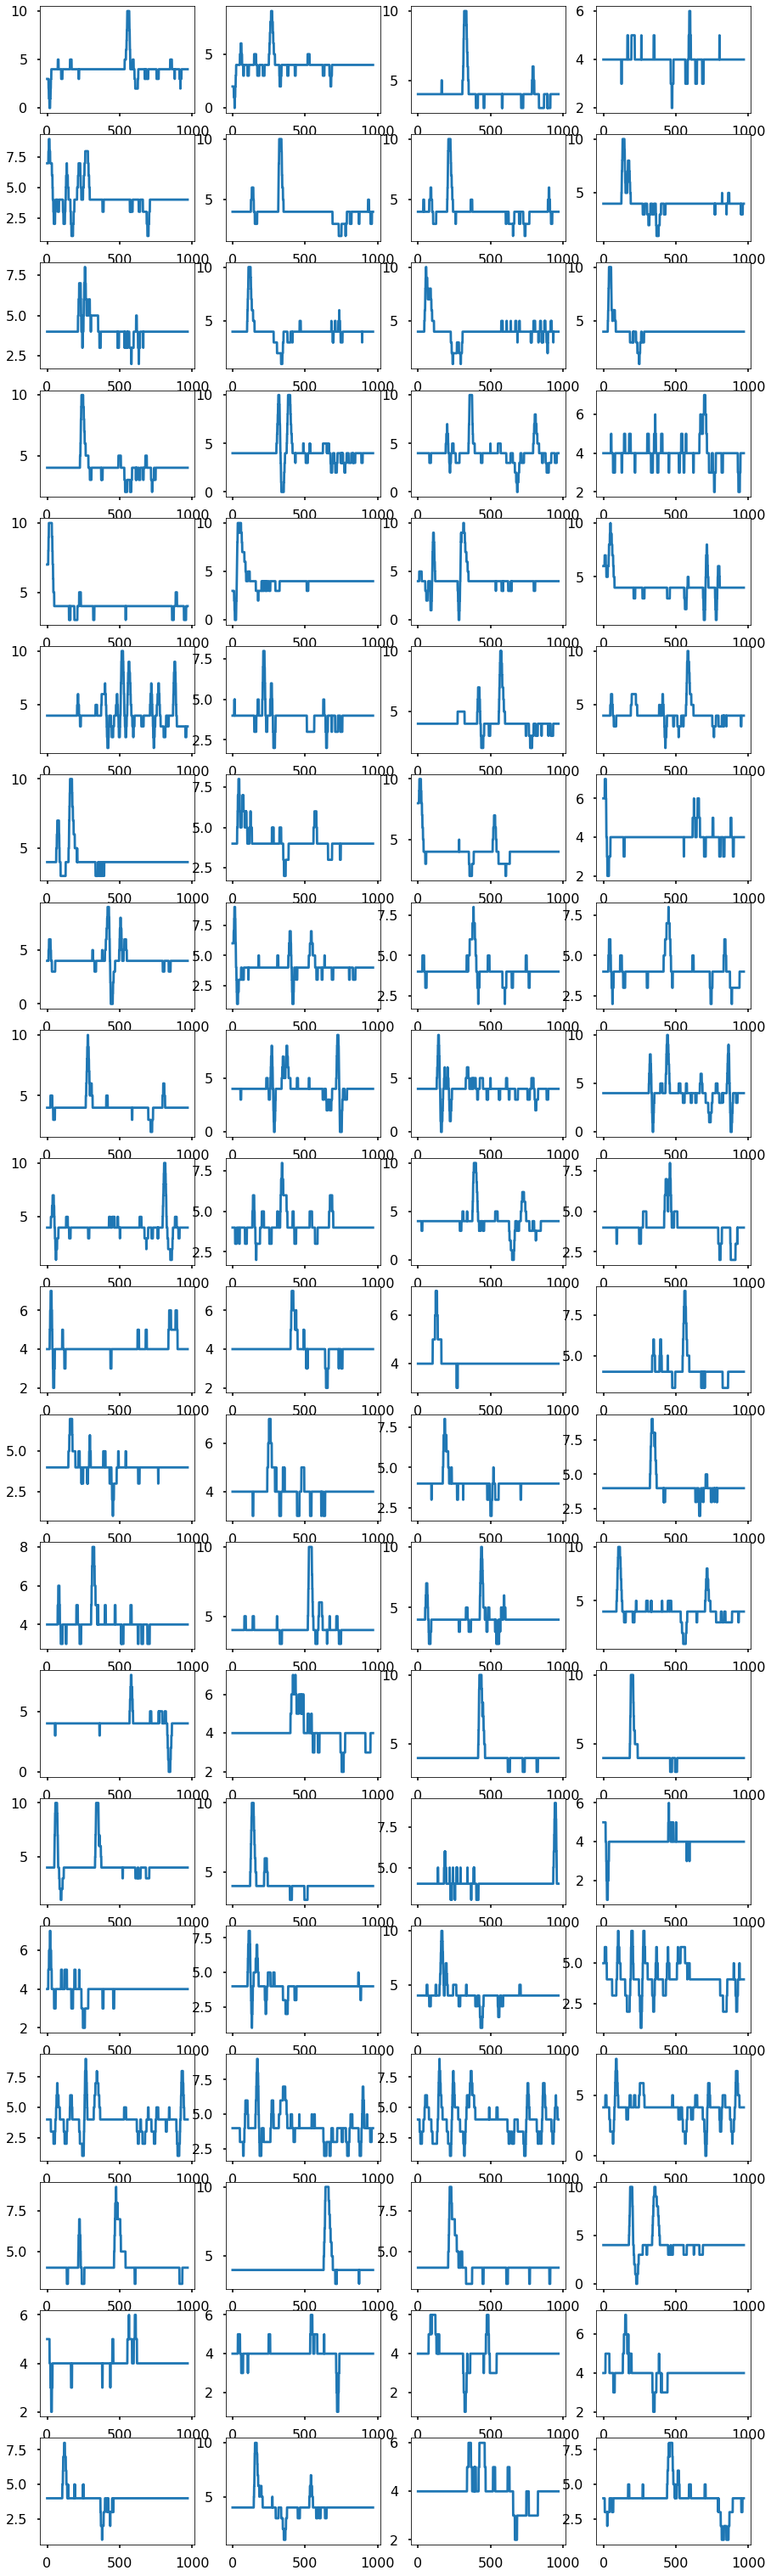

In [192]:
nrows = 20
ncols = 4
figure, ax = plt.subplots(nrows, ncols, figsize=(15, 55))

for i in tqdm(range(nrows), desc="Obtaining Stop-Indicator"):
    for j in range(ncols):
        curr_spec = narrow_specs[sample_word][ncols*i+j]
        stop_indicator = get_stop_indicator(curr_spec, window)
        discretized = discretize('stop_indicator', stop_indicator)
        ax[i,j].plot(discretized)

In [193]:
# nrows = 20
# ncols = 4
# figure, ax = plt.subplots(nrows, ncols, figsize=(15, 55))

# for i in tqdm(range(nrows), desc="Obtaining Amplitudes"):
#     for j in range(ncols):
#         curr_spec = narrow_specs[sample_word][ncols*i+j]
#         fund_range_amplitude, low_range_amplitude, high_range_amplitude = get_range_amplitudes(curr_spec, window)
#         ax[i,j].plot(fund_range_amplitude, label='fund')        
#         ax[i,j].plot(low_range_amplitude, label='lo')
#         ax[i,j].plot(high_range_amplitude, label='hi')
#         ax[i,j].legend()

In [194]:
# nrows = 20
# ncols = 4
# figure, ax = plt.subplots(nrows, ncols, figsize=(15, 55))

# for i in tqdm(range(nrows), desc="Obtaining F-Indicator..."):
#     for j in range(ncols):
#         curr_spec = narrow_specs[sample_word][ncols*i+j]
#         col_avg, mean_dist_from_avg, f_indicator = get_f_indicator(curr_spec, window)
#         ax[i,j].plot(col_avg, label='ca')        
#         ax[i,j].plot(mean_dist_from_avg, label='mdfa')
#         ax[i,j].plot(f_indicator, label='f')
#         ax[i,j].legend()

Obtaining LPC Spectrograms...: 100%|███████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.27it/s]


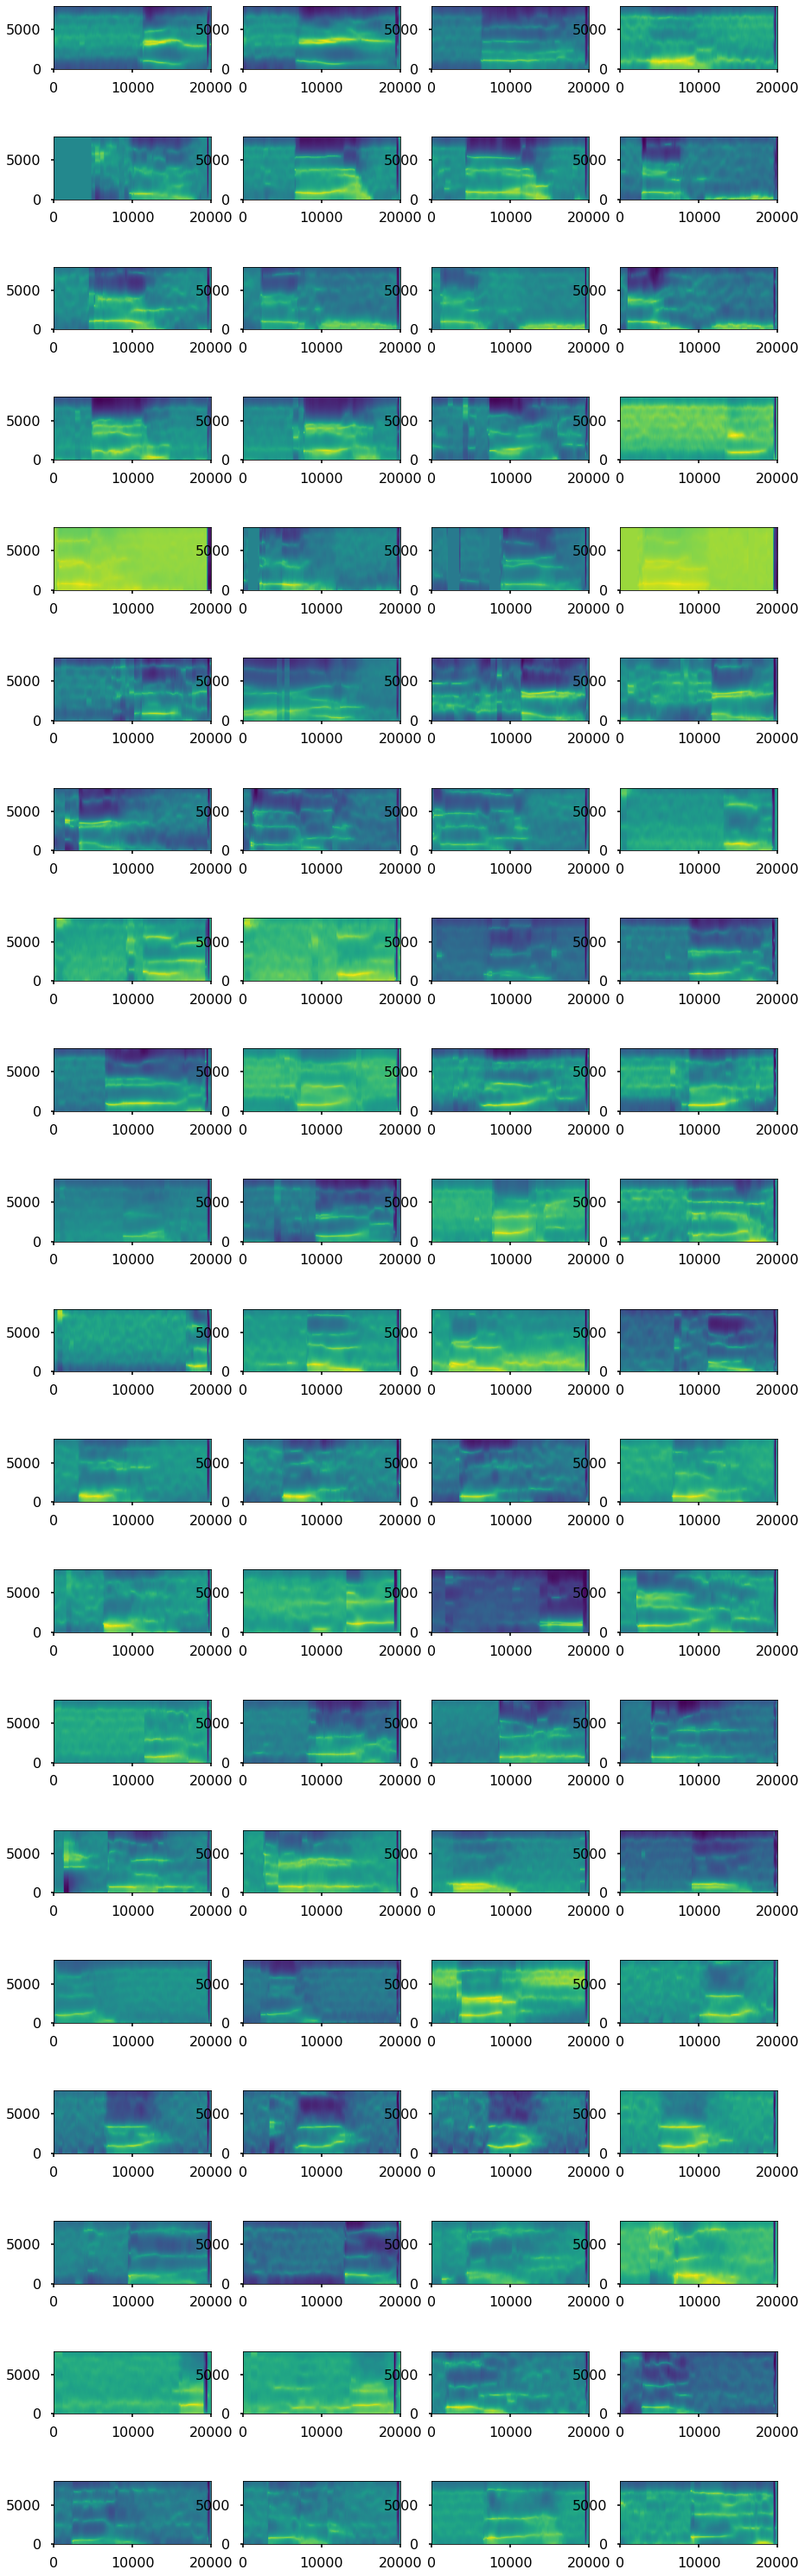

In [195]:
nrows = 20
ncols = 4
figure, ax = plt.subplots(nrows, ncols, figsize=(15, 55))

for i in tqdm(range(nrows), desc="Obtaining LPC Spectrograms..."):
    for j in range(ncols):
        curr_wav = wav_samples[ncols*i+j]
        curr_wav = read(curr_wav)[1]
        acoef_history, lpc_history, lpcf, lpc_diagram = lpc(pre_emphasize(curr_wav, pre_emph_factor), window_size=window_size, M=M, num_fft_points=num_fft_points, pad=pad)
        ax[i,j].imshow(lpc_diagram, extent=[0, 20000, 0, 8000])

Obtaining Formants...: 100%|███████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.12s/it]


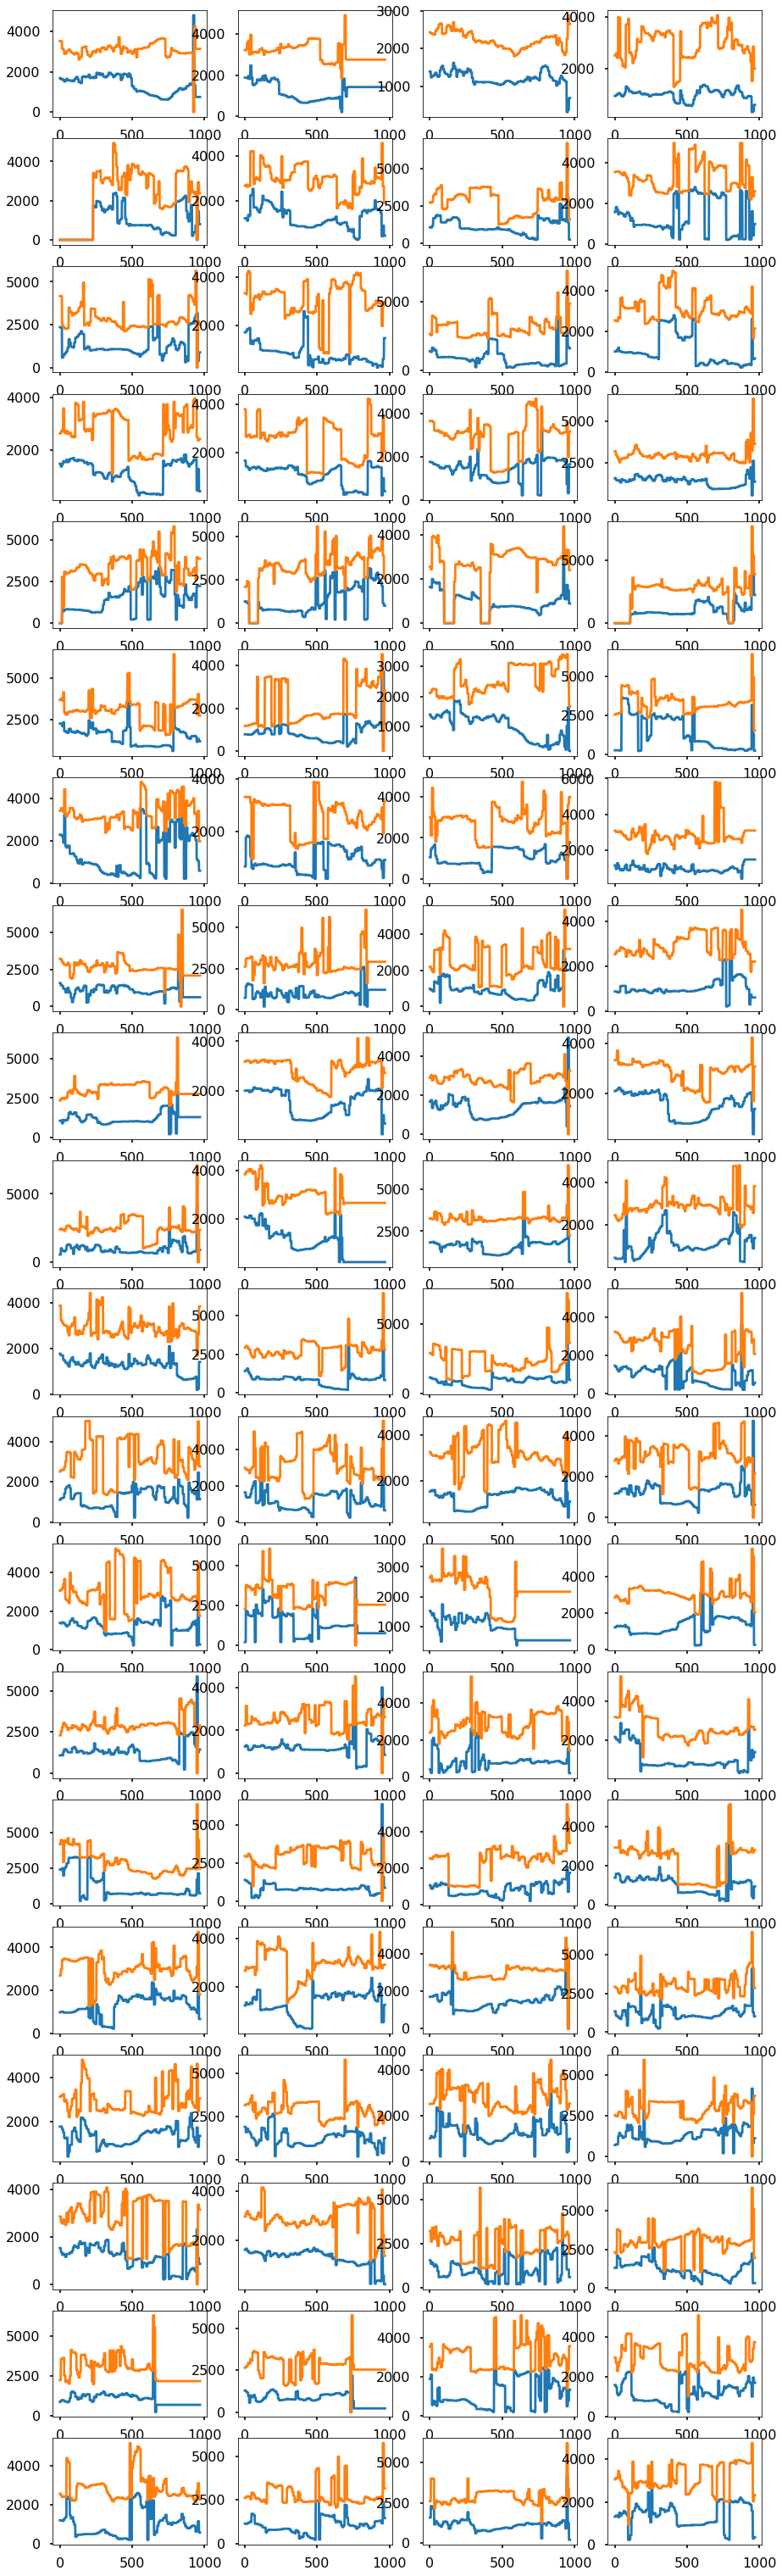

In [196]:
nrows = 20
ncols = 4
figure, ax = plt.subplots(nrows, ncols, figsize=(15, 55))

for i in tqdm(range(nrows), desc="Obtaining Formants..."):
    for j in range(ncols):
        curr_wav = wav_samples[ncols*i+j]
        curr_wav = read(curr_wav)[1]
        acoef_history, lpc_history, lpcf, lpc_diagram = lpc(pre_emphasize(curr_wav, pre_emph_factor), window_size=window_size, M=M, num_fft_points=num_fft_points, pad=pad)
        crosses_between_range_history, formant_history = formants(lpc_history, lpcf)
        discretized_formants = discretize("formants", formant_history)
        interpolated_formants = interpolate_formants(discretized_formants)
        for k in range(0,2):
            ax[i,j].plot(interpolated_formants[k])

Obtaining Formants...: 100%|███████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.13s/it]


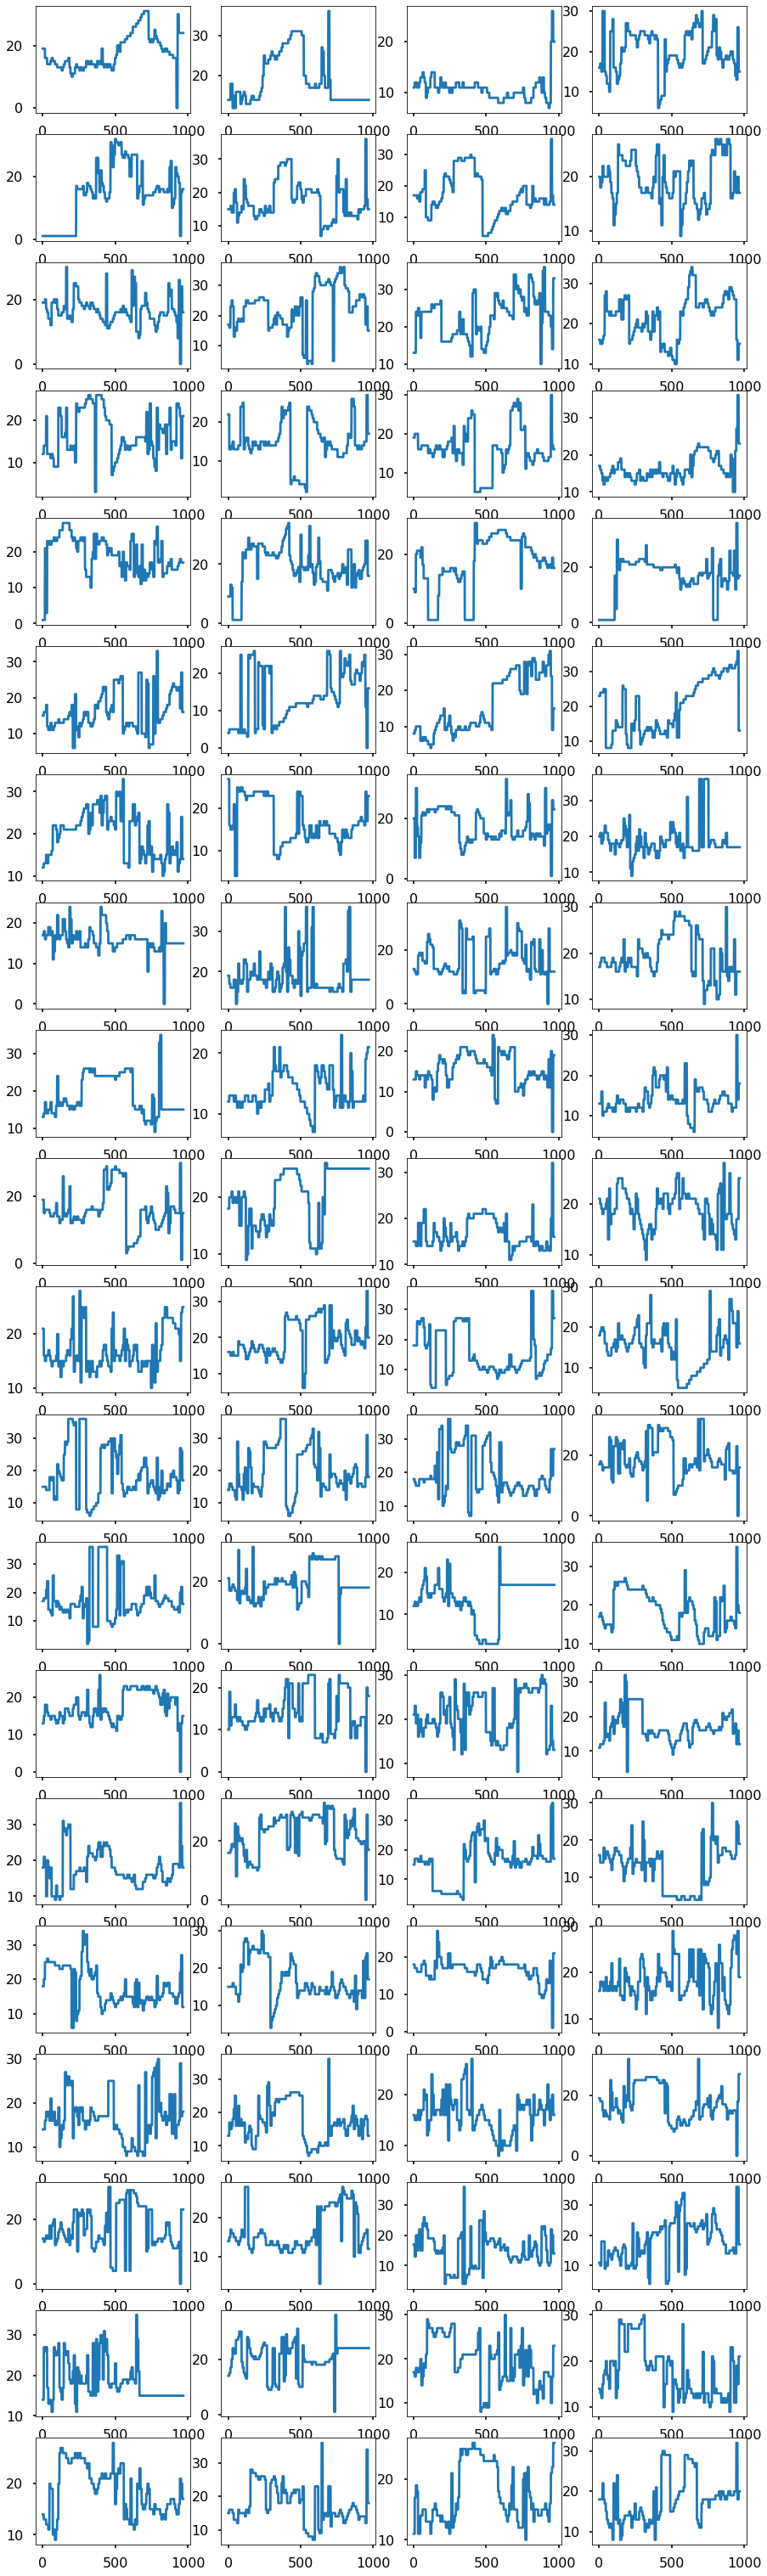

In [197]:
nrows = 20
ncols = 4
figure, ax = plt.subplots(nrows, ncols, figsize=(15, 55))

for i in tqdm(range(nrows), desc="Obtaining Formants..."):
    for j in range(ncols):
        curr_wav = wav_samples[ncols*i+j]
        curr_wav = read(curr_wav)[1]
        acoef_history, lpc_history, lpcf, lpc_diagram = lpc(pre_emphasize(curr_wav, pre_emph_factor), window_size=window_size, M=M, num_fft_points=num_fft_points, pad=pad)
        crosses_between_range_history, formant_history = formants(lpc_history, lpcf)
        f2_minus_f1 = formant_difference(formant_history)
        discretized = discretize("f2_minus_f1", f2_minus_f1)
        interpolated_formants = interpolate_formants(np.array([discretized]))
        ax[i,j].plot(interpolated_formants[0])

# Data Collection

In [33]:
on_samples = get_wavs('on', wav_path)
off_samples = get_wavs('off', wav_path)
stop_samples = get_wavs('stop', wav_path)
go_samples = get_wavs('go', wav_path)
left_samples = get_wavs('left', wav_path)
right_samples = get_wavs('right', wav_path)
yes_samples = get_wavs('yes', wav_path)
no_samples = get_wavs('no', wav_path)
up_samples = get_wavs('up', wav_path)
down_samples = get_wavs('down', wav_path)

In [158]:
def get_features(sample_word, wav_samples):
    features = []
    for i in tqdm(range(300), 'Obtaining Features for {w}...'.format(w=sample_word)): # 300 total samples for now (since we only got 300 narrow_specs)
            curr_sample_features = []
            curr_spec = narrow_specs[sample_word][i]

            stop_indicator = get_stop_indicator(curr_spec, window)
            discretized = discretize('stop_indicator', stop_indicator)
            curr_sample_features.append(discretized)

            n_indicator = get_n_indicator(curr_spec, window, lower_bound=-9)
            discretized = discretize('n_indicator', n_indicator)
            curr_sample_features.append(discretized)

            s_indicator = get_s_indicator(curr_spec, window, lower_bound=-0.1)
            discretized = discretize('s_indicator', s_indicator)
            curr_sample_features.append(discretized)

            _, _, f_indicator = get_f_indicator(curr_spec, window)
            discretized = discretize('f_indicator', f_indicator)
            curr_sample_features.append(discretized)

            curr_wav = wav_samples[i]
            curr_wav = read(curr_wav)[1]
            _, lpc_history, lpcf, _ = lpc(pre_emphasize(curr_wav, pre_emph_factor), window_size=window_size, M=M, num_fft_points=num_fft_points, pad=pad)
            _, formant_history = formants(lpc_history, lpcf)
            discretized_formants = discretize("formants", formant_history)
            interpolated_formants = interpolate_formants(discretized_formants)
            curr_sample_features.append(interpolated_formants[0])
            curr_sample_features.append(interpolated_formants[1])

            f2_minus_f1 = formant_difference(formant_history)
            discretized = discretize("f2_minus_f1", f2_minus_f1)
            interpolated_formants = interpolate_formants(np.array([discretized]))
            curr_sample_features.append(interpolated_formants[0])

            features.append(curr_sample_features)
        
    return features

In [159]:
on_features = get_features('on', on_samples)
off_features = get_features('off', off_samples)
stop_features = get_features('stop', stop_samples)
go_features = get_features('go', go_samples)
left_features = get_features('left', left_samples)
right_features = get_features('right', right_samples)
yes_features = get_features('yes', yes_samples)
no_features = get_features('no', no_samples)
up_features = get_features('up', up_samples)
down_features = get_features('down', down_samples)

Obtaining Features for down...: 100%|████████████████████████████████████████████████| 300/300 [01:56<00:00,  2.58it/s]


In [160]:
num_train = 200
num_test = 100
on_train = on_features[0:num_train]
on_test = on_features[num_train:num_train+num_test]
off_train = off_features[0:num_train]
off_test = off_features[num_train:num_train+num_test]
stop_train = stop_features[0:num_train]
stop_test = stop_features[num_train:num_train+num_test]
go_train = go_features[0:num_train]
go_test = go_features[num_train:num_train+num_test]
left_train = left_features[0:num_train]
left_test = left_features[num_train:num_train+num_test]
right_train = right_features[0:num_train]
right_test = right_features[num_train:num_train+num_test]
yes_train = yes_features[0:num_train]
yes_test = yes_features[num_train:num_train+num_test]
no_train = no_features[0:num_train]
no_test = no_features[num_train:num_train+num_test]
up_train = up_features[0:num_train]
up_test = up_features[num_train:num_train+num_test]
down_train = down_features[0:num_train]
down_test = down_features[num_train:num_train+num_test]

# HDC Util

In [79]:
""" CONSTANTS """
num_features = 7
hv_dimension = 10000
num_ngrams = 10

In [65]:
# Inputs:
# - hv_dimension  :  size of desired hv
# Random vector has exactly one-to-one 1 vs 0 ratio
def gen_rand_hv(hv_dimension):
    inds = np.arange(hv_dimension)
    np.random.shuffle(inds)
    return np.array([1 if i in inds[:hv_dimension//2] else 0 for i in range(hv_dimension)])

In [66]:
# Inputs:
# - hvs  :  list of np.arrays
def bundle(hvs):
    output = np.array([0]*len(hvs[0]))
    for i in hvs:
        output = np.add(output, i)
    return (output > (len(hvs) // 2)) + 0

In [67]:
# Inputs:
# - hvs  :  list of np.arrays
def bind(hvs):
    output = np.array([0]*len(hvs[0]))
    for i in hvs:
        output = np.bitwise_xor(output, i)
    return output

In [68]:
# Inputs:
# - hv  :  np.array
# - p   :  permute factor (eg. 1)
def permute(hv, p):
    return np.roll(hv, shift=p) 

In [69]:
# Inputs:
# - hv  :  np.array
def rule90(hv):
    hv_left = np.roll(hv, shift=-1)
    hv_right = np.roll(hv, shift=1)
    return bind([hv_left, hv_right])

In [70]:
# Inputs:
# - seed_hv :  starting seed hv (np.array)
# - num_hvs :  number of hvs to generate from seed_hv using rule90. First hv will be the seed_hv
def gen_hvs_from_rule90(seed_hv, num_hvs):
    hvs = seed_hv.reshape(-1, len(seed_hv))
    for i in range(num_hvs-1):
        hvs = np.vstack([hvs, rule90(hvs[len(hvs)-1])])
    return hvs

In [71]:
# Inputs:
# - hv1 : np.array
# - hv2 : np.array
def hamming(hv1, hv2):
    return np.count_nonzero(hv1 != hv2)

In [74]:
# Generates a num_discrete_pieces x hv_dimension list of cim vectors
# Vectors are generated by flipping num_bits_per_piece bits each time
# example: gen_cim_memory(10000, 256)
def gen_cim_memory(hv_dimension, num_discrete_pieces):
    num_bits_per_piece = int(hv_dimension / num_discrete_pieces)
    initial_hv = curr_hv = gen_rand_hv(hv_dimension)
    final_hv = 1 - initial_hv # flip all the bits
    indices = np.arange(hv_dimension)
    random.shuffle(indices)
    hvs = curr_hv
    for i in range(num_discrete_pieces-2):
        curr_hv = np.array([1-x if ind in indices[i*num_bits_per_piece:i*num_bits_per_piece+num_bits_per_piece] else x for ind, x in enumerate(curr_hv)])
        hvs = np.vstack([hvs, curr_hv])
    hvs = np.vstack([hvs, final_hv])
    return hvs

In [137]:
# Assuming ordering of features -> [stop, n, s, f, f1, f2, f2_minus_f1]
def gen_frame_cim(stop_indicator_cim, n_indicator_cim, s_indicator_cim, f_indicator_cim, f1_f2_cim, f2_minus_f1_cim, curr_sample, time):
    curr_stop = curr_sample[0][time]
    curr_n = curr_sample[1][time]
    curr_s = curr_sample[2][time]
    curr_f = curr_sample[3][time]
    curr_f1 = curr_sample[4][time]
    curr_f2 = curr_sample[5][time]
    curr_f2_minus_f1 = curr_sample[6][time]
    
    curr_stop_hv = stop_indicator_cim[curr_stop]
    curr_n_hv = n_indicator_cim[curr_n]
    curr_s_hv = s_indicator_cim[curr_s]
    curr_f_hv = f_indicator_cim[curr_f]
    curr_f1_hv = f1_f2_cim[curr_f1//5]
    curr_f2_hv = f1_f2_cim[curr_f2//5]
    curr_f2_minus_f1_hv = f2_minus_f1_cim[curr_f2_minus_f1]
    
    return np.stack((curr_stop_hv,curr_n_hv,curr_s_hv,curr_f_hv,curr_f1_hv,curr_f2_hv,curr_f2_minus_f1_hv))

In [72]:
# Inputs:
# - im  :  item memory (2d np.array, num_mels * hv_dimension)
# - cim :  continuous item memory per sample (2d np.array, num_mels * hv_dimension)
def spatial_encoder(im, cim):
    accumulate = []
    for i,c in zip(im, cim):
        accumulate.append(bind([i, c]))
    return bundle(accumulate)

In [73]:
# Inputs:
# - num_ngrams  :  number of ngrams (eg. 3)
# - te_in       :  new hv coming into TE
# - ngrams_in   :  initial condition for remaining ngrams (list of num_ngrams-1 hvs)
# Outputs: 
# - ngrams_out  :  output ngrams (2d np.array, list of num_ngrams-1 hvs)
# - te_out      :  single hv from binding ngrams

# ------- Example Usage ------ #
# num_ngrams = 3
# first_ngrams = [np.array([0,0,0,0,0]), np.array([0,0,0,0,0])]
# first_hv = [np.array([1,0,0,0,0])]
# second_hv = [np.array([1,1,0,0,0])]
# third_hv = [np.array([1,1,1,0,0])]
#
# te_out_1, second_ngrams = temporal_encoder(num_ngrams, first_hv, first_ngrams)
# te_out_2, third_ngrams = temporal_encoder(num_ngrams, second_hv, second_ngrams)
# te_out_3, fourth_ngrams = temporal_encoder(num_ngrams, third_hv, third_ngrams)
# ---------------------------- #

def temporal_encoder(num_ngrams, te_in, ngrams_in):
    assert len(ngrams_in) == num_ngrams-1
    
    ngrams = te_in + ngrams_in
    te_out = bind(ngrams)
    ngrams.pop()
    for i in range(len(ngrams)):
        ngrams[i] = permute(ngrams[i], 1)
    ngrams_out = ngrams
    
    return te_out, ngrams_out

# HDC Train

In [153]:
len(on_train[0][6])

946

In [162]:
def train(train_data, im, stop_indicator_cim, n_indicator_cim, s_indicator_cim, f_indicator_cim, f1_f2_cim, f2_minus_f1_cim):
    recording_hvs = []
    for r in tqdm(range(len(train_data)), desc="Training..."): # Iterate over each training sample
        ngrams = [np.array([0]*hv_dimension)]*(num_ngrams-1)
        frame_hvs = []
        for f in range(len(train_data[0][0])): # Iterate over the entire time-frame of the sample
            frame_cim = gen_frame_cim(stop_indicator_cim, n_indicator_cim, s_indicator_cim, f_indicator_cim, f1_f2_cim, f2_minus_f1_cim, train_data[r], f)
            se = spatial_encoder(im, frame_cim)
            te, ngrams = temporal_encoder(num_ngrams, [se], ngrams)
            frame_hvs.append(te)
        recording_prototype = bundle(frame_hvs) # Bundle all of the TE outputs per time frame
        recording_hvs.append(recording_prototype)
    train_data_prototype = bundle(recording_hvs)
    
    return train_data_prototype, recording_hvs

In [132]:
im = gen_hvs_from_rule90(gen_rand_hv(hv_dimension), num_features)

In [133]:
stop_indicator_cim = gen_cim_memory(hv_dimension, 11)
n_indicator_cim = gen_cim_memory(hv_dimension, 17)
s_indicator_cim = gen_cim_memory(hv_dimension, 14)
f_indicator_cim = gen_cim_memory(hv_dimension, 18)
f1_f2_cim = gen_cim_memory(hv_dimension, 1601)
f2_minus_f1_cim = gen_cim_memory(hv_dimension, 37)

In [164]:
on_prototype, on_recording_hvs = train(on_train, im, stop_indicator_cim, n_indicator_cim, s_indicator_cim, f_indicator_cim, f1_f2_cim, f2_minus_f1_cim)
off_prototype, off_recording_hvs = train(off_train, im, stop_indicator_cim, n_indicator_cim, s_indicator_cim, f_indicator_cim, f1_f2_cim, f2_minus_f1_cim)
print(hamming(on_prototype, off_prototype))
stop_prototype, stop_recording_hvs = train(stop_train, im, stop_indicator_cim, n_indicator_cim, s_indicator_cim, f_indicator_cim, f1_f2_cim, f2_minus_f1_cim)
print(hamming(stop_prototype, off_prototype))
go_prototype, go_recording_hvs = train(go_train, im, stop_indicator_cim, n_indicator_cim, s_indicator_cim, f_indicator_cim, f1_f2_cim, f2_minus_f1_cim)
left_prototype, left_recording_hvs = train(left_train, im, stop_indicator_cim, n_indicator_cim, s_indicator_cim, f_indicator_cim, f1_f2_cim, f2_minus_f1_cim)
right_prototype, right_recording_hvs = train(right_train, im, stop_indicator_cim, n_indicator_cim, s_indicator_cim, f_indicator_cim, f1_f2_cim, f2_minus_f1_cim)
yes_prototype, yes_recording_hvs = train(yes_train, im, stop_indicator_cim, n_indicator_cim, s_indicator_cim, f_indicator_cim, f1_f2_cim, f2_minus_f1_cim)
no_prototype, no_recording_hvs = train(no_train, im, stop_indicator_cim, n_indicator_cim, s_indicator_cim, f_indicator_cim, f1_f2_cim, f2_minus_f1_cim)
up_prototype, up_recording_hvs = train(up_train, im, stop_indicator_cim, n_indicator_cim, s_indicator_cim, f_indicator_cim, f1_f2_cim, f2_minus_f1_cim)
down_prototype, down_recording_hvs = train(down_train, im, stop_indicator_cim, n_indicator_cim, s_indicator_cim, f_indicator_cim, f1_f2_cim, f2_minus_f1_cim)

Training...:   0%|                                                                             | 0/200 [00:00<?, ?it/s]

829


Training...:   0%|                                                                             | 0/200 [00:00<?, ?it/s]

860


Training...: 100%|███████████████████████████████████████████████████████████████████| 200/200 [17:59<00:00,  5.40s/it]


# HDC Test

In [165]:
# Inputs:
# - test_data            :  entire dataset for a specific label (eg. on, off, etc.)
# - actual_label         :  number for each label: on-0, off-1, stop-2, go-3, left-4, right-5, yes-6, no-7, up-8, down-9

def test(test_data, actual_label, im, stop_indicator_cim, n_indicator_cim, s_indicator_cim, f_indicator_cim, f1_f2_cim, f2_minus_f1_cim):
    num_correct = 0
    num_incorrect = 0
    confusion_array = np.array([0]*10)
    confusion_entries = {}
    
    for r in tqdm(range(len(test_data)), desc="Testing..."):
        ngrams = [np.array([0]*hv_dimension)]*(num_ngrams-1)
        frame_hvs = []
        for f in range(len(test_data[0][0])):
            frame_cim = gen_frame_cim(stop_indicator_cim, n_indicator_cim, s_indicator_cim, f_indicator_cim, f1_f2_cim, f2_minus_f1_cim, test_data[r], f)
            se = spatial_encoder(im, frame_cim)
            te, ngrams = temporal_encoder(num_ngrams, [se], ngrams)
            frame_hvs.append(te)
        recording_prototype = bundle(frame_hvs) # Bundle all of the TE outputs per time frame

        on_distance = hamming(recording_prototype, on_prototype)
        off_distance = hamming(recording_prototype, off_prototype)
        stop_distance = hamming(recording_prototype, stop_prototype)
        go_distance = hamming(recording_prototype, go_prototype)
        left_distance = hamming(recording_prototype, left_prototype)
        right_distance = hamming(recording_prototype, right_prototype)
        yes_distance = hamming(recording_prototype, yes_prototype)
        no_distance = hamming(recording_prototype, no_prototype)
        up_distance = hamming(recording_prototype, up_prototype)
        down_distance = hamming(recording_prototype, down_prototype)

        distances = [on_distance,off_distance,stop_distance,go_distance,left_distance,right_distance,yes_distance,no_distance,up_distance,down_distance]
        predicted_label = distances.index(min(distances))
        if (predicted_label == actual_label):
            num_correct += 1
        else:
            num_incorrect += 1
        
        confusion_array[predicted_label] += 1
        confusion_entries[r] = predicted_label
        
    return num_correct / (num_correct + num_incorrect), confusion_array / (num_correct + num_incorrect), confusion_entries

In [166]:
on_accuracy, on_conf_array, on_confusion_entries = test(on_test, 0, im, stop_indicator_cim, n_indicator_cim, s_indicator_cim, f_indicator_cim, f1_f2_cim, f2_minus_f1_cim)
print("On", on_accuracy, on_conf_array)
off_accuracy, off_conf_array, off_confusion_entries = test(off_test, 1, im, stop_indicator_cim, n_indicator_cim, s_indicator_cim, f_indicator_cim, f1_f2_cim, f2_minus_f1_cim)
print("Off", off_accuracy, off_conf_array)
stop_accuracy, stop_conf_array, stop_confusion_entries = test(stop_test, 2, im, stop_indicator_cim, n_indicator_cim, s_indicator_cim, f_indicator_cim, f1_f2_cim, f2_minus_f1_cim)
print("Stop", stop_accuracy, stop_conf_array)
go_accuracy, go_conf_array, go_confusion_entries = test(go_test, 3, im, stop_indicator_cim, n_indicator_cim, s_indicator_cim, f_indicator_cim, f1_f2_cim, f2_minus_f1_cim)
print("Go", go_accuracy, go_conf_array)
left_accuracy, left_conf_array, left_confusion_entries = test(left_test, 4, im, stop_indicator_cim, n_indicator_cim, s_indicator_cim, f_indicator_cim, f1_f2_cim, f2_minus_f1_cim)
print("Left", left_accuracy, left_conf_array)
right_accuracy, right_conf_array, right_confusion_entries = test(right_test, 5, im, stop_indicator_cim, n_indicator_cim, s_indicator_cim, f_indicator_cim, f1_f2_cim, f2_minus_f1_cim)
print("Right", right_accuracy, right_conf_array)
yes_accuracy, yes_conf_array, yes_confusion_entries = test(yes_test, 6, im, stop_indicator_cim, n_indicator_cim, s_indicator_cim, f_indicator_cim, f1_f2_cim, f2_minus_f1_cim)
print("Yes", yes_accuracy, yes_conf_array)
no_accuracy, no_conf_array, no_confusion_entries = test(no_test, 7, im, stop_indicator_cim, n_indicator_cim, s_indicator_cim, f_indicator_cim, f1_f2_cim, f2_minus_f1_cim)
print("No", no_accuracy, no_conf_array)
up_accuracy, up_conf_array, up_confusion_entries = test(up_test, 8, im, stop_indicator_cim, n_indicator_cim, s_indicator_cim, f_indicator_cim, f1_f2_cim, f2_minus_f1_cim)
print("Up", up_accuracy, up_conf_array)
down_accuracy, down_conf_array, down_confusion_entries = test(down_test, 9, im, stop_indicator_cim, n_indicator_cim, s_indicator_cim, f_indicator_cim, f1_f2_cim, f2_minus_f1_cim)
print("Down", down_accuracy, down_conf_array)

Testing...:   0%|                                                                              | 0/100 [00:00<?, ?it/s]

On 0.08 [0.08 0.01 0.09 0.09 0.05 0.1  0.01 0.12 0.1  0.35]


Testing...:   0%|                                                                              | 0/100 [00:00<?, ?it/s]

Off 0.1 [0.12 0.1  0.12 0.02 0.06 0.06 0.02 0.15 0.18 0.17]


Testing...:   0%|                                                                              | 0/100 [00:00<?, ?it/s]

Stop 0.21 [0.04 0.03 0.21 0.03 0.07 0.08 0.01 0.05 0.16 0.32]


Testing...:   0%|                                                                              | 0/100 [00:00<?, ?it/s]

Go 0.06 [0.05 0.03 0.06 0.06 0.   0.05 0.01 0.15 0.27 0.32]


Testing...:   0%|                                                                              | 0/100 [00:00<?, ?it/s]

Left 0.25 [0.02 0.   0.07 0.05 0.25 0.14 0.06 0.06 0.07 0.28]


Testing...:   0%|                                                                              | 0/100 [00:00<?, ?it/s]

Right 0.38 [0.   0.01 0.07 0.07 0.11 0.38 0.01 0.02 0.11 0.22]


Testing...:   0%|                                                                              | 0/100 [00:00<?, ?it/s]

Yes 0.17 [0.02 0.   0.02 0.01 0.15 0.15 0.17 0.02 0.16 0.3 ]


Testing...:   0%|                                                                              | 0/100 [00:00<?, ?it/s]

No 0.15 [0.05 0.   0.1  0.08 0.04 0.06 0.01 0.15 0.19 0.32]


Testing...:   0%|                                                                              | 0/100 [00:00<?, ?it/s]

Up 0.28 [0.03 0.03 0.12 0.05 0.01 0.12 0.01 0.09 0.28 0.26]


Testing...: 100%|████████████████████████████████████████████████████████████████████| 100/100 [16:22<00:00,  9.82s/it]

Down 0.34 [0.01 0.01 0.08 0.04 0.05 0.19 0.01 0.07 0.2  0.34]


Average: 0.202


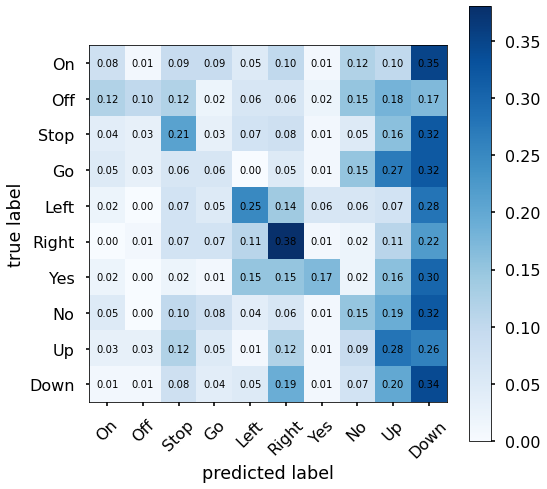

In [167]:
# Imports
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Your Confusion Matrix
cm = np.array([on_conf_array,
               off_conf_array,
              stop_conf_array,
              go_conf_array,
              left_conf_array,
              right_conf_array,
              yes_conf_array,
              no_conf_array,
              up_conf_array,
              down_conf_array])

# Find average
avg = 0
for i in range(len(cm[0])):
    avg += cm[i][i]
avg = avg / len(cm[0])
print("Average:", avg)

# Classes
classes = ['On', 'Off', 'Stop', 'Go', 'Left', 'Right', 'Yes', 'No', 'Up', 'Down']

figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   class_names = classes,
                                   show_absolute = False,
                                   show_normed = True,
                                   colorbar = True,
                                   figsize=(8, 8))

plt.show()

In [221]:
right_confusion_entries

{0: 9,
 1: 3,
 2: 3,
 3: 5,
 4: 5,
 5: 8,
 6: 8,
 7: 8,
 8: 8,
 9: 4,
 10: 7,
 11: 3,
 12: 5,
 13: 5,
 14: 5,
 15: 5,
 16: 9,
 17: 2,
 18: 2,
 19: 9,
 20: 2,
 21: 9,
 22: 9,
 23: 5,
 24: 5,
 25: 5,
 26: 5,
 27: 6,
 28: 5,
 29: 5,
 30: 3,
 31: 8,
 32: 8,
 33: 4,
 34: 9,
 35: 8,
 36: 9,
 37: 9,
 38: 9,
 39: 5,
 40: 5,
 41: 4,
 42: 4,
 43: 8,
 44: 3,
 45: 9,
 46: 2,
 47: 9,
 48: 9,
 49: 5,
 50: 5,
 51: 5,
 52: 5,
 53: 5,
 54: 9,
 55: 9,
 56: 2,
 57: 5,
 58: 5,
 59: 5,
 60: 5,
 61: 5,
 62: 5,
 63: 8,
 64: 2,
 65: 5,
 66: 4,
 67: 4,
 68: 9,
 69: 9,
 70: 9,
 71: 9,
 72: 9,
 73: 3,
 74: 4,
 75: 2,
 76: 8,
 77: 8,
 78: 4,
 79: 4,
 80: 5,
 81: 5,
 82: 5,
 83: 5,
 84: 1,
 85: 5,
 86: 5,
 87: 5,
 88: 4,
 89: 9,
 90: 9,
 91: 9,
 92: 3,
 93: 7,
 94: 5,
 95: 5,
 96: 4,
 97: 5,
 98: 5,
 99: 5}

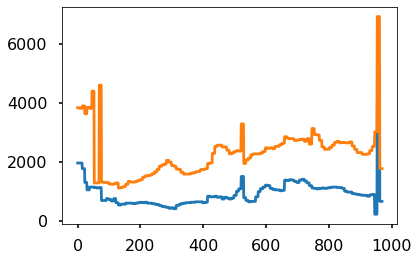

In [227]:
plt.plot(right_test[99][4])
plt.plot(right_test[99][5])

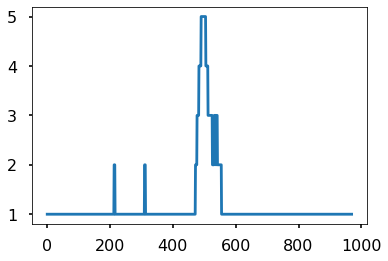

In [211]:
plt.plot(off_test[33][3])

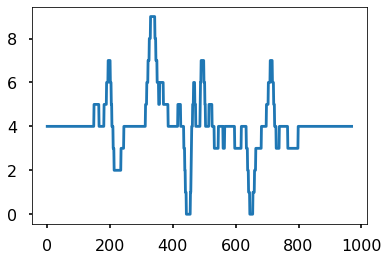

In [180]:
plt.plot(stop_test[0][0])

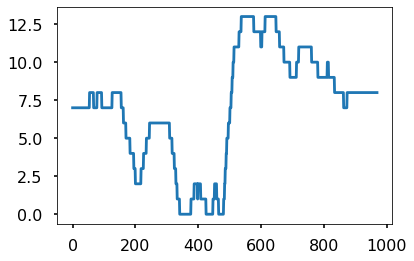

In [181]:
plt.plot(stop_test[0][1])

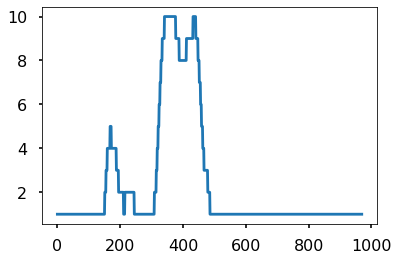

In [182]:
plt.plot(stop_test[0][2])

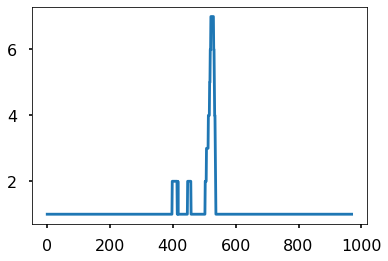

In [183]:
plt.plot(stop_test[0][3])

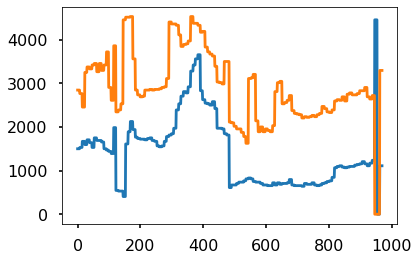

In [199]:
plt.plot(stop_test[0][4])
plt.plot(stop_test[0][5])

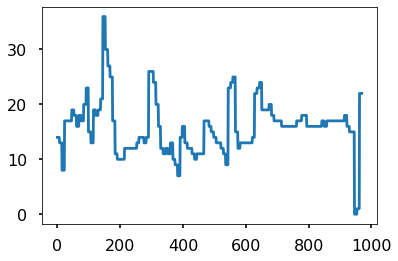

In [186]:
plt.plot(stop_test[0][6])

# Extra

In [158]:
# nrows = 20
# ncols = 4
# figure, ax = plt.subplots(nrows, ncols, figsize=(15, 55))

# for i in tqdm(range(nrows), desc="Obtaining Formants with LPC Mask..."):
#     for j in range(ncols):
#         curr_wav = wav_samples[ncols*i+j]
#         try:
#             curr_wav = read(curr_wav)[1]
#         except:
#             continue
#         acoef_history, lpc_history, lpcf, lpc_diagram = lpc(pre_emphasize(curr_wav, 0.98), window_size=480, M=14, num_fft_points=256, pad=True)
#         crosses_between_range_history, formant_history = formants(lpc_history, lpcf)
#         masked_formants = mask_formant_with_lpc(formant_history, lpc_history, threshold=0.5)
#         for k in range(0,3):
#             ax[i,j].plot(masked_formants[k])

In [159]:
# nrows = 20
# ncols = 4
# figure, ax = plt.subplots(nrows, ncols, figsize=(15, 55))

# for i in tqdm(range(nrows), desc="Obtaining Formants with Voicing Mask..."):
#     for j in range(ncols):
#         curr_wav = wav_samples[ncols*i+j]
#         try:
#             curr_wav = read(curr_wav)[1]
#         except:
#             continue
#         acoef_history, lpc_history, lpcf, lpc_diagram = lpc(pre_emphasize(curr_wav, 0.98), window_size=480, M=14, num_fft_points=256, pad=True)
#         crosses_between_range_history, formant_history = formants(lpc_history, lpcf)
#         curr_spec = narrow_specs[sample_word][ncols*i+j]
#         voicing_amplitude, discrete_voicing, _ = voicing(curr_spec, threshold=0.7, window=15)
#         ax[i,j].plot(voicing_amplitude)

In [160]:
# nrows = 20
# ncols = 4
# figure, ax = plt.subplots(nrows, ncols, figsize=(15, 55))

# for i in tqdm(range(nrows), desc="Obtaining Formants with Voicing Mask..."):
#     for j in range(ncols):
#         curr_wav = wav_samples[ncols*i+j]
#         try:
#             curr_wav = read(curr_wav)[1]
#         except:
#             continue
#         acoef_history, lpc_history, lpcf, lpc_diagram = lpc(pre_emphasize(curr_wav, 0.98), window_size=480, M=14, num_fft_points=256, pad=True)
#         crosses_between_range_history, formant_history = formants(lpc_history, lpcf)
#         curr_spec = narrow_specs[sample_word][ncols*i+j]
#         voicing_amplitude, discrete_voicing, _ = voicing(curr_spec, threshold=0.7, window=15)
#         m = mask_formant_with_voicing(formant_history, discrete_voicing)
#         for k in range(0,3):
#             ax[i,j].plot(m[k])

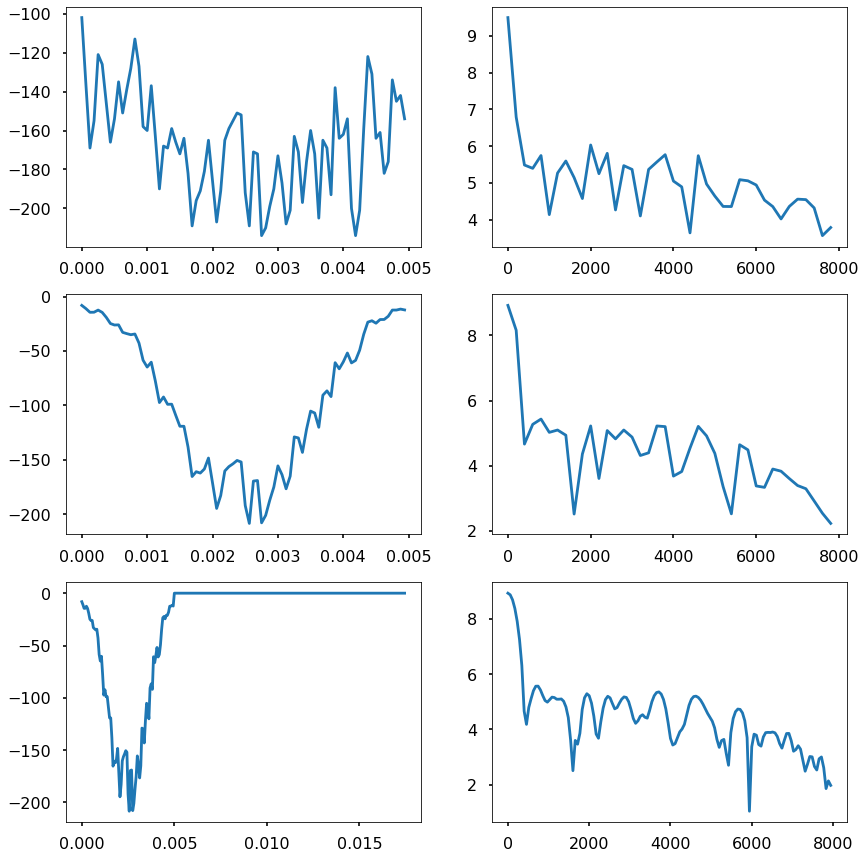

In [153]:
nrows = 3
ncols = 2
figure, ax = plt.subplots(nrows, ncols, figsize=(14,15))

# ----- Time domain of original window ----- #
sr = 16000 # 16 KHz
ts = 1.0/sr
t = np.arange(0,ts*window_size,ts)
x = windows[85]

ax[0,0].plot(t, x)

# ----- Freq. response of original window ----- #
X = DFT(x)
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 

ax[0,1].plot(freq[0:len(freq)//2], np.log(abs(X)[0:len(X)//2])) # // 2 to only plot below Nyquist

# ----- Time domain after windowing ----- #
x_windowed = x * np.hamming(80)
ax[1,0].plot(t, x_windowed)

# ----- Freq. response of windowed window ----- #
X_windowed = DFT(x_windowed)
ax[1,1].plot(freq[0:len(freq)//2], np.log(abs(X_windowed)[0:len(X_windowed)//2])) # // 2 to only plot below Nyquist

# ----- Zero-pad signal to increase freq. resolution ----- #
num_padding = 200
x_padded = np.concatenate([x_windowed, np.array([0]*num_padding)])
t_padded = np.arange(0, ts*(window_size+num_padding), ts)
ax[2,0].plot(t_padded, x_padded)

# ----- Freq. response of padded window ----- #
X_padded = DFT(x_padded)
N_padded = len(X_padded)
n_padded = np.arange(N_padded)
T_padded = N_padded/sr
freq_padded = n_padded/T_padded
ax[2,1].plot(freq_padded[0:len(freq_padded)//2], np.log(abs(X_padded)[0:len(X_padded)//2])) # // 2 to only plot below Nyquist

In [ ]:
# spectrogram = get_spectrogram(curr_wav, band='narrowband')
# plt.imshow(spectrogram, extent=[0, 20000, 0, 8000])
# plt.xlabel("couple hundreds of seconds")
# plt.ylabel("Hz")

In [ ]:
# words = ['off', 'stop', 'go']
# for sample_word in words:
#     wav_samples = [wav_path/sample_word/f for f in listdir(wav_path/sample_word) if isfile(join(wav_path/sample_word, f))]

#     for w in tqdm(range(301), desc="Obtaining Spectrograms..."):
#         curr_wav = wav_samples[w]
#         try:
#             curr_wav = read(curr_wav)[1]
#         except:
#             continue
#         spectrogram = get_spectrogram(curr_wav, band='narrowband')
#         np.savetxt("custom_spectrograms/narrowband/" + sample_word + "/" + wav_samples[w].__str__().split('\\')[-1].split('.')[0] + ".csv", spectrogram, delimiter=',')